## Importing required packages

In [ ]:
# Importing required packages and function to connect to GCP

import pandas as pd  # Import the Pandas library for data manipulation.
import os  # Import the OS library for working with the operating system.F
from datetime import timedelta  # Import timedelta from datetime for time-related calculations.

# Access data using Google BigQuery.
from google.colab import auth  # Import the authentication module from Google Colab.
from google.cloud import bigquery  # Import the BigQuery client library.

# Authenticate the user to access Google BigQuery data.
auth.authenticate_user()

# Set up environment variables for the Google Cloud project.
project_id = 'physionet-data-395201'  # Replace with your own project ID.
if project_id == 'physionet-data':
    raise ValueError('You must change project_id to your GCP project.')

os.environ["GOOGLE_CLOUD_PROJECT"] = project_id  # Set the project ID as an environment variable.

# Read data from BigQuery into Pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect='standard'
    )

# Set the dataset you want to work with in BigQuery.
dataset = 'mimiciv'

## Project Flow and stages


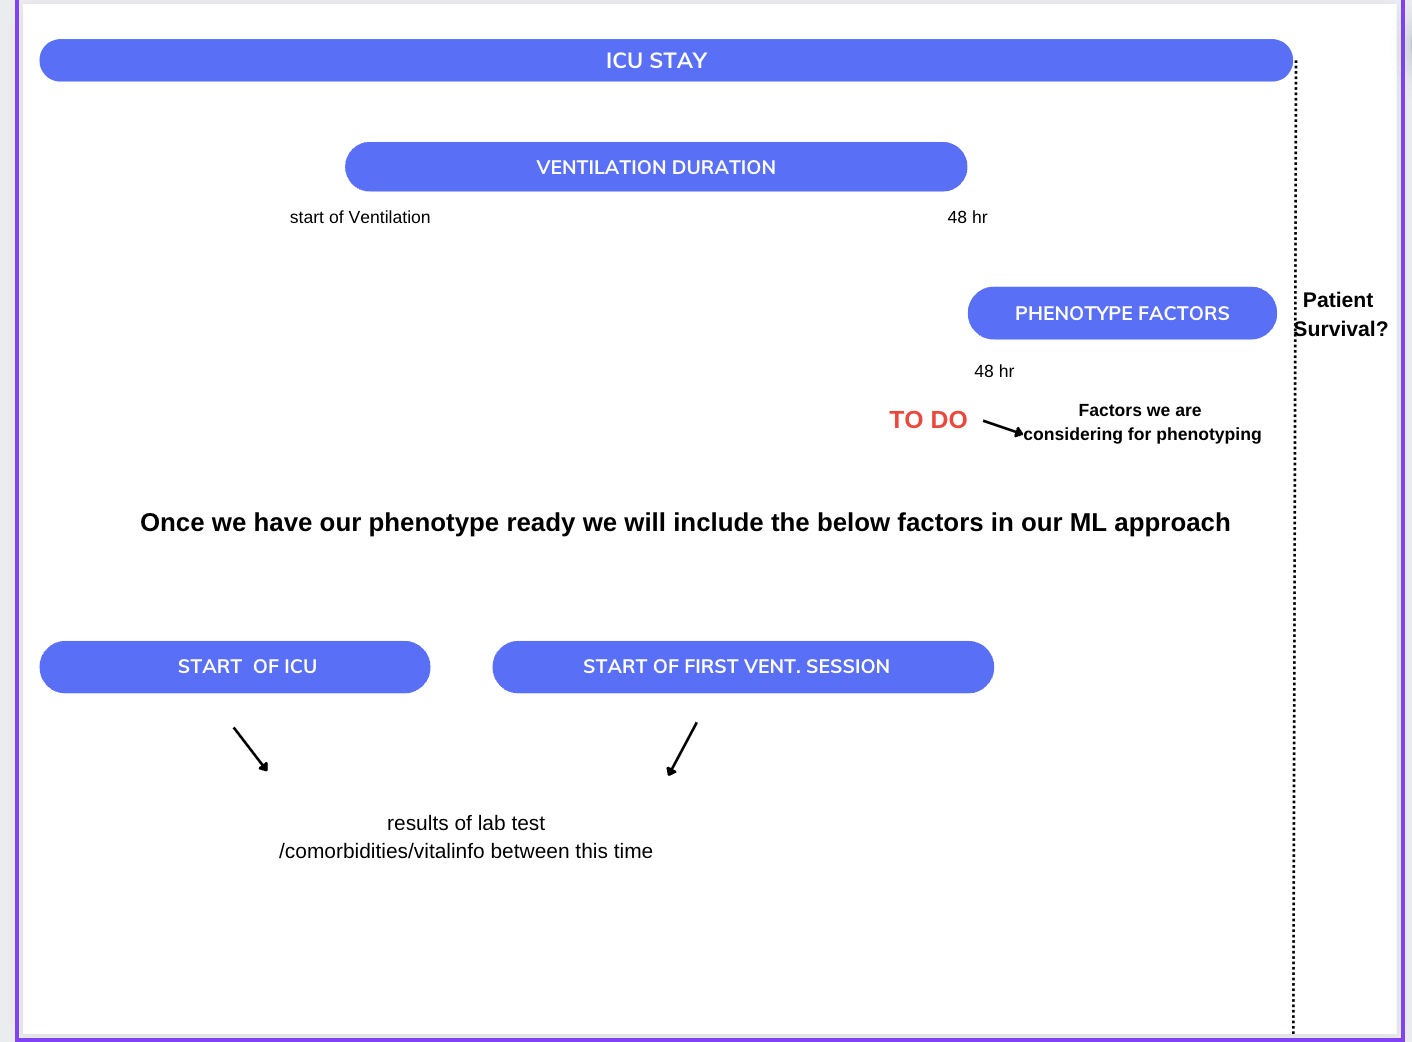

##Digital Phenotyping

# Explanation of the code's purpose and logic
**Ventilator-Associated Pneumonia (VAP) Definition for Phenotyping:**

In the context of this analysis, Ventilator-Associated Pneumonia is defined as follows:

**1. Mechanical Ventilation Duration:**  
   - **Duration >= 48 Hours**: Patients who have been on mechanical ventilation for a duration of 48 hours or longer.

**2. Clinical Indicators:**
   - **Leukocytosis and Fever**: Patients who exhibit leukocytosis (an elevated white blood cell count) and fever after 48 hours of ventilation and before the end of their ICU stay.

**3. Microbiology Events (bacterial growth):**
   - **High Value for Tracheal Aspirates**: Patients with microbiology events showing high values for tracheal aspirates.
   - **High Value for Mini-BAL**: Patients with microbiology events showing high values for mini-BAL (mini-bronchoalveolar lavage).
   - **High Value for PSB**: Patients with microbiology events showing high values for protected specimen brush (PSB).

These criteria are used for phenotyping and identifying cases of Ventilator-Associated Pneumonia (VAP) within the dataset.

# Explanation of the code's purpose and logic
**Final Phenotype Identification**

In the final phenotype identification, we are looking for patients who meet one of the following sets of criteria:

1. **Mechanical Ventilation Duration** and **Clinical Indicators**: Patients who have a prolonged duration of mechanical ventilation, and they exhibit specific clinical indicators such as Leukocytosis and Fever.
   
   - *OR*

2. **Mechanical Ventilation Duration** and **Microbiology Events**: Patients who have a prolonged duration of mechanical ventilation and experience significant microbiology events, specifically high values in tests like tracheal aspirates, mini-BAL, or PSB (Protected Specimen Brush).


# Explanation of the code's purpose and logic
## Step 1: First we find the patients with ventilation more than 48 hours

# Explanation of the code's purpose and logic
#### Step 1a: To Find Patients with ICU Stays > 48 Hours

**Step Description:**
In this step, we focus on identifying patients who have spent more than 48 hours in the intensive care unit (ICU).

**Methodology:**
1. We begin by considering patients in the ICU setting.
2. The primary objective is to distinguish patients who have had ICU stay of more than 48 hours.

A patient undergoes ventilation inbetween the ICU stays. **Hence, to get the patients with more than 48 hrs of ventilation, we first find patients with ICU time greater than 48 hours.**

In [ ]:

# Query to find patients with ICU stays greater than 48 hours

# Defining the SQL query
icu_admission_query = '''
SELECT
    subject_id,                            -- Patient identifier
    icu_stay.intime AS icu_intime,         -- Admission time to the ICU
    icu_stay.outtime AS icu_outtime,       -- Discharge time from the ICU
    icu_stay.los AS los,                   -- Length of stay in the ICU
    icu_stay.rn AS icu_seq,                -- ICU Stay Sequence
    icu_stay.total_icu_stays               -- Total number of ICU stays for the patient (>24hrs)
FROM (
    SELECT
        subject_id,
        hadm_id,
        first_careunit,
        last_careunit,
        intime,
        outtime,
        los,
        ROW_NUMBER() OVER (PARTITION BY subject_id ORDER BY intime ASC) AS rn,
        COUNT(*) OVER (PARTITION BY subject_id) AS total_icu_stays
    FROM `physionet-data.mimiciv_icu.icustays`
) AS icu_stay
WHERE icu_stay.los >= 2 -- Filter for ICU stays longer than 48 hours
ORDER BY subject_id;
'''

# Running the query and storing the result in a DataFrame
icu_admission_table = run_query(icu_admission_query)

# Displaying the first few rows of the resulting DataFrame
icu_admission_table.head()


,subject_id,icu_intime,icu_outtime,los,icu_seq,total_icu_stays
0,10001884,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,1,1
1,10002155,2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,1,3
2,10002155,2130-09-24 00:50:00,2130-09-27 22:13:41,3.891447,2,3
3,10002348,2112-11-30 23:24:00,2112-12-10 18:25:13,9.792512,1,1
4,10002428,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,1,4


In [ ]:
# Distinct subject ids
icu_admission_table_distinct_subject_ids = icu_admission_table['subject_id'].drop_duplicates()
icu_admission_table_distinct_subject_ids = icu_admission_table_distinct_subject_ids.tolist()
len(icu_admission_table_distinct_subject_ids)

27192

# Explanation of the code's purpose and logic
#### Step 1b: To Find Patients with Ventilation Stays > 48 Hours

**Step Description:**
In this step, we focus on identifying patients who have spent more than 48 hours in the ventilation sessions.

**Methodology:**
1. We begin by considering patients in the "FinishedRunning" stage of ventilation.
2. The primary objective is to distinguish patients who have had ventilation sessions of more than 48 hours.

**Notes:**
1. We are considering all the ventilation types, i.e. Invasive, Non-Invasive and Mask.
2. In the modelling stage, we will use ventilation type as a factor to see if the **impact of the ventilation type on the mortality.**

In [ ]:
#Create a Common Table Expression (CTE) named VentilationItemID
#This CTE selects item IDs and labels from the d_items table for items related to ventilation.
patients_with_vent_session = run_query("""

WITH VentilationSessions AS (
SELECT
    pe.subject_id,                      -- Patient identifier
    pe.starttime AS vent_starttime,      -- Start time of the procedure
    pe.endtime AS vent_endtime,          -- End time of the procedure
    vid.label AS ventilation_type,       -- Label description for the ventilation item
    CASE
        WHEN pe.value >= 2880 THEN pe.value -- 48hours has 2880 mins
        ELSE NULL
    END AS vent_duration,               -- Duration of the procedure (null for values < 2880)
    pe.valueuom AS duration_unit,        -- Unit of measurement for duration
    pe.patientweight,                   -- Patient's weight at the time of the procedure
    ROW_NUMBER() OVER (PARTITION BY pe.subject_id ORDER BY pe.starttime) AS vent_seq_no,
    COUNT(*) OVER (PARTITION BY pe.subject_id) AS total_vent_stays
FROM `physionet-data.mimiciv_icu.procedureevents` AS pe
JOIN (
    SELECT itemid, label
    FROM `physionet-data.mimiciv_icu.d_items`
    WHERE LOWER(label) LIKE '%ventilation%'
) AS vid ON vid.itemid = pe.itemid
WHERE pe.statusdescription LIKE 'FinishedRunning'
ORDER BY pe.subject_id, pe.starttime)

SELECT  subject_id,
        vent_starttime,
        vent_endtime,
        ventilation_type,
        vent_duration,
        duration_unit,
        patientweight,
        vent_seq_no,
        total_vent_stays
FROM VentilationSessions
WHERE vent_duration IS NOT NULL


""")
patients_with_vent_session.head()

,subject_id,vent_starttime,vent_endtime,ventilation_type,vent_duration,duration_unit,patientweight,vent_seq_no,total_vent_stays
0,10001884,2131-01-13 04:00:00,2131-01-19 17:45:00,Invasive Ventilation,9465.0,min,65.0,3,4
1,10001884,2131-01-15 04:07:00,2131-01-19 17:43:00,Invasive Ventilation,6576.0,min,65.0,4,4
2,10002428,2156-04-19 20:10:00,2156-04-22 17:05:00,Invasive Ventilation,4135.0,min,43.0,1,3
3,10002428,2156-05-11 16:05:00,2156-05-20 10:45:00,Invasive Ventilation,12640.0,min,48.4,3,3
4,10003400,2137-02-25 23:37:00,2137-02-28 14:17:00,Invasive Ventilation,3760.0,min,93.0,1,4


In [ ]:
# Distinct subject ids with ventilation session
patients_with_vent_session_distinct_subject_ids = patients_with_vent_session['subject_id'].drop_duplicates()
patients_with_vent_session_distinct_subject_ids = patients_with_vent_session_distinct_subject_ids.tolist()
len(patients_with_vent_session_distinct_subject_ids)

8368

# Explanation of the code's purpose and logic
#### Step 1c: We combine the results obtained in step 1a and 1b.

**Step Description:**
In this step, we focus on filtering the patients who have had ICU stays greater than 48hrs AND ventilation sessions greater than 48 hours

**Methodology:**
1. We combined the two dataframes obtained in step 1a and step 1b.
2. Intuitively, the ventilation stay should start between the ICU stays. But, there are some patients whose ventilation started some minutes before their ICU intime. **Hence, i have added a delta of 15 mins**

**Result:**
1. The resulting table combines information about patients' ICU stays and ventilation sessions. For each ICU stay lasting more than 48 hours, the table will include rows corresponding to all ventilation sessions that lasted more than 48 hours during that specific ICU stay.

In [ ]:
#Perform inner join
result_df = pd.merge(icu_admission_table, patients_with_vent_session, on='subject_id', how='inner')

In [ ]:
# filter
ventilation_and_icu_data = result_df[
    (result_df['vent_starttime'] >= result_df['icu_intime'] - pd.Timedelta(minutes=15)) & (result_df['vent_endtime'] <= result_df['icu_outtime'])]

In [ ]:
# result data
ventilation_and_icu_data = ventilation_and_icu_data[['subject_id', 'icu_seq', 'total_icu_stays',
                                                     'icu_intime','icu_outtime', 'los',
                                                     'vent_seq_no', 'total_vent_stays',
                                                     'vent_starttime','vent_endtime', 'vent_duration', 'duration_unit', 'patientweight' ]]

In [ ]:
# Distinct subject ids
ventilation_and_icu_data_distinct_subject_ids = ventilation_and_icu_data['subject_id'].drop_duplicates()
ventilation_and_icu_data_distinct_subject_ids = ventilation_and_icu_data_distinct_subject_ids.tolist()
len(ventilation_and_icu_data_distinct_subject_ids)

8034

**End of Step 1**

In this step, we have identified a total of 8034 patients who met the following criteria:

- They had ICU stays lasting more than 48 hours.
- During these extended ICU stays, these patients also had ventilation sessions that lasted more than 48 hours.

## Step 2: Identifying Patients with Clinical Indicators**

In this step, we aim to identify patients with clinical indicators, Leukocytosis and Fever. The criteria for this identification are as follows:

- We will consider the test results for the observations **that were charted after patients have undergone ventilation sessions lasting 48 hours or more and before the respective ICU end time associated with that ventilation session.**


**Step 2a: Identifying Patients Diagnosed with Fever**

In this step, we focus on the patients identified in the previous step and determine if they were diagnosed with fever, defined as a body temperature exceeding 38 degrees Celsius.

**Step Description:**
1. We utilize a query to retrieve all body temperature tests where the recorded temperature exceeds 38 degrees Celsius for the patients identified in Step 1.
2. Subsequently, we filter the tests to include only **those performed after 48 hours of the ventilation session and before the respective ICU end time associated with that ventilation session.**


In [ ]:
query = f"""

WITH TempInfo AS (
  SELECT itemid, label
    FROM `physionet-data.mimiciv_icu.d_items`
    WHERE LOWER(label) LIKE '%temperature celsius%'
    OR LOWER(label) LIKE '%temperature fahrenheit%'
    OR LOWER(label) LIKE '%temperaturef_apacheiv%'
)

SELECT
    lb.subject_id,                         -- Patient identifier
    lb.charttime,                          -- Vital sign chart time
    lb.valuenum ,                         -- Vital sign value number
    lb.valueuom                            -- UoM

FROM
    `physionet-data.mimiciv_icu.chartevents` AS lb,
    TempInfo as ti

where lb.itemid = ti.itemid
AND lb.subject_id IN ({', '.join(map(str, ventilation_and_icu_data_distinct_subject_ids))})  -- Filter for specified subject IDs
AND ((lb.valuenum > 38 AND lb.valueuom LIKE '%C') OR (lb.valuenum > 100.4 AND lb.valueuom LIKE '%F'))


"""

# Execute the query and retrieve patient demographic information.
patients_with_fever = run_query(query)

# Display the first few rows of the result.
patients_with_fever.head()

,subject_id,charttime,valuenum,valueuom
0,15456778,2159-01-16 20:00:00,39.9,°C
1,19689280,2118-01-23 00:00:00,103.3,°F
2,18729201,2135-04-24 20:00:00,103.4,°F
3,16890177,2178-02-22 18:27:00,39.2,°C
4,17414351,2179-10-08 06:00:00,981.0,°F


**Filter the tests to include only those performed after 48 hours of the ventilation session and before the respective ICU end time associated with that ventilation session.**

In [ ]:
result_df = pd.merge(ventilation_and_icu_data, patients_with_fever, on='subject_id', how='inner')

In [ ]:
patients_with_fever_after_48hr_ventilation = result_df[
    (result_df['charttime'] >= result_df['vent_starttime'] + timedelta(hours=48)) &
    (result_df['charttime'] <= result_df['icu_outtime'])
]

In [ ]:
#renaming the column names to make it more readable
patients_with_fever_after_48hr_ventilation.rename(columns={'valuenum': 'body_temp', 'valueuom': 'temp_scale', 'charttime': 'temp_charttime',
                                                           'los': 'icu_los', 'duration_unit': 'vent_duration_unit'}, inplace=True)


<ipython-input-13-a4ee555a8c4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_with_fever_after_48hr_ventilation.rename(columns={'valuenum': 'body_temp', 'valueuom': 'temp_scale', 'charttime': 'temp_charttime',


In [ ]:
patients_with_fever_after_48hr_ventilation.head()

,subject_id,icu_seq,total_icu_stays,icu_intime,icu_outtime,icu_los,vent_seq_no,total_vent_stays,vent_starttime,vent_endtime,vent_duration,vent_duration_unit,temp_charttime,body_temp,temp_scale
4,10002428,2,4,2156-04-19 18:11:19,2156-04-26 18:58:41,7.032894,1,3,2156-04-19 20:10:00,2156-04-22 17:05:00,4135.0,min,2156-04-22 00:00:00,100.9,°F
19,10002428,4,4,2156-05-11 14:49:34,2156-05-22 14:16:46,10.977222,3,3,2156-05-11 16:05:00,2156-05-20 10:45:00,12640.0,min,2156-05-17 20:00:00,101.7,°F
20,10004235,1,1,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,1,1,2196-02-24 16:52:00,2196-02-27 16:28:00,4296.0,min,2196-02-29 05:00:00,101.3,°F
64,10004401,5,7,2144-04-21 20:49:00,2144-05-01 13:53:03,9.711146,6,8,2144-04-21 21:23:00,2144-05-01 13:53:00,13950.0,min,2144-04-24 14:00:00,100.6,°F
68,10004401,5,7,2144-04-21 20:49:00,2144-05-01 13:53:03,9.711146,6,8,2144-04-21 21:23:00,2144-05-01 13:53:00,13950.0,min,2144-04-26 20:00:00,100.7,°F


In [ ]:
# Distinct subject ids
patients_with_fever_after_48hr_ventilation_distinct_subject_ids = patients_with_fever_after_48hr_ventilation['subject_id'].drop_duplicates()
patients_with_fever_after_48hr_ventilation_distinct_subject_ids = patients_with_fever_after_48hr_ventilation_distinct_subject_ids.tolist()
len(patients_with_fever_after_48hr_ventilation_distinct_subject_ids)

4354

**Step 2b: Identifying Patients Diagnosed with Leukocytosis**

In this step, we focus on the patients identified in the previous step and determine if they were diagnosed with Leukocytosis or Leukopenia.

Leukocytosis (white blood cell count ≥ 12 K/uL) or leukopenia (white blood cell count < 4 K/uL)

**Step Description:**
1. We utilize a query to retrieve all White blood cell lab tests done for the patients diagnosed with fever and meets the defined Leukocytosis OR leukopenia definition.
2. Subsequently, we filter the tests to include only **those performed after 48 hours of the ventilation session and before the respective ICU end time associated with that ventilation session.**

In [ ]:
query = f"""

WITH WBCInfo AS (
  SELECT itemid
    FROM `physionet-data.mimiciv_hosp.d_labitems`
    WHERE LOWER(label) LIKE '%white blood cells%'
)

SELECT
    lb.subject_id,                         -- Patient identifier
    lb.charttime AS WBC_charttime,                          -- Vital sign chart time
    lb.valuenum AS WBC_count ,                         -- Vital sign value number
    lb.valueuom AS WBC_scale                          -- UoM

FROM
    `physionet-data.mimiciv_hosp.labevents` AS lb,
    WBCInfo as wi

where lb.itemid = wi.itemid
AND (lb.valuenum >= 12 OR lb.valuenum < 4)
AND valueuom like 'K/uL'
AND lb.subject_id IN ({', '.join(map(str, patients_with_fever_after_48hr_ventilation_distinct_subject_ids))})  -- Filter for specified subject IDs
"""

# Execute the query and retrieve patient demographic information.
patients_with_leukocytosis = run_query(query)

# Display the first few rows of the result.
patients_with_leukocytosis.head()

,subject_id,WBC_charttime,WBC_count,WBC_scale
0,10004401,2144-01-27 10:36:00,23.2,K/uL
1,10035168,2143-12-28 10:35:00,1.1,K/uL
2,10035168,2144-12-23 00:00:00,0.2,K/uL
3,10035168,2145-11-30 11:10:00,1.4,K/uL
4,10035168,2145-12-03 09:20:00,1.0,K/uL


**Filter the tests to include only those performed after 48 hours of the ventilation session and before the respective ICU end time associated with that ventilation session.**

In [ ]:
result_df = pd.merge(ventilation_and_icu_data, patients_with_leukocytosis, on='subject_id', how='inner')

In [ ]:
patients_with_leukocytosis_and_fever_after_48hr_ventilation = result_df[
    (result_df['WBC_charttime'] >= result_df['vent_starttime'] + timedelta(hours=48)) &
    (result_df['WBC_charttime'] <= result_df['icu_outtime'])
]

In [ ]:
# Distinct subject ids
patients_with_leukocytosis_and_fever_after_48hr_ventilation_distinct_subject_ids = patients_with_leukocytosis_and_fever_after_48hr_ventilation['subject_id'].drop_duplicates()
patients_with_leukocytosis_and_fever_after_48hr_ventilation_distinct_subject_ids = patients_with_leukocytosis_and_fever_after_48hr_ventilation_distinct_subject_ids.tolist()
len(patients_with_leukocytosis_and_fever_after_48hr_ventilation_distinct_subject_ids)

3474

**End of Step 2**

In this step, we have identified a total of 3474 patients who meet a combination of two key criteria:

1. **ICU Stays and Ventilation Sessions**: These patients had ICU stays lasting more than 48 hours, and during these extended ICU stays, they also had ventilation sessions that persisted for more than 48 hours.

**AND**

2. **Clinical Indicator Criteria**: We further refined our identification to focus on patients who were diagnosed with specific clinical indicators, including fever, leukocytosis, and leukopenia. These diagnostic criteria were assessed after the patients' 48-hour ventilation sessions and before the respective ICU end times for those ventilation sessions.


## Step 3: Identification of patients with Microbiology Events (bacterial growth).

•Endotracheal aspirates: ≥1,000,000 colony forming units (cfu)/mL

•Bronchoscopic- or mini-BAL: 10,000 cfu/mL

•PSB: 1000 cfu/mL

In this step, we aim to count the pulmonary pathogens using the readings mentioned above. The criteria for this identification are as follows:

- We will consider the test results for the observations **that were charted after patients have undergone ventilation sessions lasting 48 hours or more and before the respective ICU end time associated with that ventilation session.**

In [ ]:
query = f"""

SELECT
    subject_id,
    spec_type_desc as path_spec_type_desc,
    charttime AS path_charttime,
    CASE
        WHEN LOWER(spec_type_desc) LIKE '%tracheal aspirate%' THEN 'Endotracheal aspirates – ≥1,000,000 colony forming units (cfu)/mL'
        WHEN LOWER(spec_type_desc) LIKE '%bronchial brush%' THEN 'Bronchoscopic- or mini-BAL – 10,000 cfu/mL'
        WHEN LOWER(spec_type_desc) LIKE '%mini-bal%' THEN 'Bronchoscopic- or mini-BAL – 10,000 cfu/mL'
        ELSE NULL
    END AS path_comment_data
FROM `physionet-data.mimiciv_hosp.microbiologyevents`
WHERE (
    -- Filter spec_type_desc
    (
        LOWER(spec_type_desc) LIKE '%tracheal aspirate%'
        OR LOWER(spec_type_desc) LIKE '%bronchial brush%'
        OR LOWER(spec_type_desc) LIKE '%mini-bal%'
    )
    -- Filter negative comments
    AND comments IS NOT NULL
    AND LOWER(comments) NOT LIKE '%absent%'
    AND comments NOT LIKE '___'
    AND comments NOT LIKE '%NO POLYMORPHONUCLEAR LEUKOCYTES SEEN%'
    AND comments NOT LIKE '%NO MYCOBACTERIA%'
    AND comments NOT LIKE '%NO MICROORGANISMS SEEN.%'
    AND (
        comments NOT LIKE '%NO FUNGUS ISOLATED%'
        AND comments NOT LIKE '%NO ACID FAST BACILLI SEEN ON CONCENTRATED SMEAR%'
        AND comments NOT LIKE '%NO GROWTH%'
        AND comments NOT LIKE '%NO VIRUS ISOLATED%'
        AND comments NOT LIKE '%NO LEGIONELLA ISOLATED%'
        AND comments NOT LIKE '%NO ANAEROBES ISOLATED%'
        AND comments NOT LIKE '%NO NOCARDIA ISOLATED%'
        AND comments NOT LIKE '%No Cytomegalovirus (CMV) isolated%'
        AND comments NOT LIKE '%No Herpes simplex (HSV) virus isolated%'
        AND comments NOT LIKE '%NO FUNGAL ELEMENTS SEEN%'
    )
    -- Additional filters for invalid events
    AND LOWER(comments) NOT LIKE '%test cancelled%'
    AND LOWER(comments) NOT LIKE '%invalid%'
    AND LOWER(comments) NOT LIKE '%not detected%'
    AND LOWER(comments) NOT LIKE '%unknown amount%'
    AND LOWER(comments) NOT LIKE '%no respiratory viruses isolated%'
    AND LOWER(comments) NOT LIKE '%rare growth%'
    AND LOWER(comments) NOT LIKE '%sparse growth%'
    AND LOWER(comments) NOT LIKE '%negative%'
)
and charttime is not null;

"""

# Execute the query and retrieve patient demographic information.
pulmonary_pathogens_info = run_query(query)

# Display the first few rows of the result.
pulmonary_pathogens_info.head()

,subject_id,path_spec_type_desc,path_charttime,path_comment_data
0,12811031,Mini-BAL,2151-07-02 13:36:00,"Bronchoscopic- or mini-BAL – 10,000 cfu/mL"
1,11725159,Mini-BAL,2140-05-26 04:51:00,"Bronchoscopic- or mini-BAL – 10,000 cfu/mL"
2,19576505,Mini-BAL,2165-04-10 06:53:00,"Bronchoscopic- or mini-BAL – 10,000 cfu/mL"
3,17417573,Mini-BAL,2208-07-22 17:10:00,"Bronchoscopic- or mini-BAL – 10,000 cfu/mL"
4,18272532,Mini-BAL,2124-12-31 16:08:00,"Bronchoscopic- or mini-BAL – 10,000 cfu/mL"


**Filter the tests to include only those performed after 48 hours of the ventilation session and before the respective ICU end time associated with that ventilation session.**

In [ ]:
result_df = pd.merge(ventilation_and_icu_data, pulmonary_pathogens_info, on='subject_id', how='inner')

In [ ]:
patients_with_abnormal_bacterial_growth_after_48hr_ventilation = result_df[
    (result_df['path_charttime'] >= result_df['vent_starttime'] + timedelta(hours=48)) &
    (result_df['path_charttime'] <= result_df['icu_outtime'])
]

In [ ]:
# Distinct subject ids
patients_with_abnormal_bacterial_growth_after_48hr_ventilation_distinct_subject_ids = patients_with_abnormal_bacterial_growth_after_48hr_ventilation['subject_id'].drop_duplicates()
patients_with_abnormal_bacterial_growth_after_48hr_ventilation_distinct_subject_ids = patients_with_abnormal_bacterial_growth_after_48hr_ventilation_distinct_subject_ids.tolist()
len(patients_with_abnormal_bacterial_growth_after_48hr_ventilation_distinct_subject_ids)

299

**End of Step 3**

In this step, we have identified a total of 299 patients who meet a combination of two key criteria:

1. **ICU Stays and Ventilation Sessions**: These patients had ICU stays lasting more than 48 hours, and during these extended ICU stays, they also had ventilation sessions that persisted for more than 48 hours.

**AND**

2. **Microbiology Events (bacterial growth)**: We further refined our identification to focus on patients who surpassed the threshold value of the pulmonary pathogens. These diagnostic criteria were assessed after the patients' 48-hour ventilation sessions and before the respective ICU end times for those ventilation sessions.


**Final Phenotype Identification**

In the final phenotype identification, we are looking for patients who meet one of the following sets of criteria:

1. **Mechanical Ventilation Duration** and **Clinical Indicators**: Patients who have a prolonged duration of mechanical ventilation, and they exhibit specific clinical indicators such as Leukocytosis and Fever.

**For this, we have identified 3474 patients.**
   
   - *OR*

2. **Mechanical Ventilation Duration** and **Microbiology Events**: Patients who have a prolonged duration of mechanical ventilation and experience significant microbiology events, specifically high values in tests like tracheal aspirates, mini-BAL, or PSB (Protected Specimen Brush).

**For this, we have identified 299 patients.**

#### Next, we will combine the patients obtained from both the condition and that will make our **Final phenotype.**

In [ ]:
final_phenotype_patients = list(set(patients_with_abnormal_bacterial_growth_after_48hr_ventilation_distinct_subject_ids +
         patients_with_leukocytosis_and_fever_after_48hr_ventilation_distinct_subject_ids))

In [ ]:
len(final_phenotype_patients)

3538

### ***OUR FINAL PHENOTYPE HAS 3538 patients***

---



**Important Note: We Are Not Utilizing the ICD Table**

It's crucial to emphasize that in our current analysis, we are not making use of the ICD (International Classification of Diseases) table. Our primary objective at this stage is to verify the accuracy of our phenotyping conditions, ensuring they correctly identify the desired patient criteria.

**WE ARE NOT USING ICD TABLE.**


#Checking how many are there in the ICD code diagnosis table (NOT USING IT FOR ANY FILTARATION)

In [ ]:
# Selecting from ICD code diagnosis table
query = f"""
       With VAP_ICD AS (
  SELECT icd_code, long_title
  FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses`
  WHERE
  --ventilator associated pneumonia
  lower(icd_code) LIKE '99731%'
  OR lower(icd_code) LIKE 'j95851%'
)
SELECT di.subject_id
FROM `physionet-data.mimiciv_hosp.diagnoses_icd` as di
JOIN VAP_ICD as ICDEvents ON ICDEvents.icd_code = di.icd_code
AND di.hadm_id IS NOT NULL
AND di.subject_id IN ({', '.join(map(str, final_phenotype_patients))})  -- Filter for specified subject IDs
"""
df_t = run_query(query)
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   subject_id  1091 non-null   Int64
dtypes: Int64(1)
memory usage: 9.7 KB


#GETTING INFORMATION FOR THE IDENTIFIED PATIENTS

Total phenotype length: 3538

### Extracting important information we got from Step 1

In [ ]:
# Create a copy of the original DataFrame to work with
icu_admission_table_sum = icu_admission_table.copy()

# Calculate the total ICU duration for each patient (subject_id) by summing the 'los' column within each group
icu_admission_table_sum['total_icu_duration'] = icu_admission_table.groupby('subject_id')['los'].transform('sum')

# Select and retain only the columns 'subject_id', 'total_icu_stays', and 'total_icu_duration'
icu_admission_table_sum = icu_admission_table_sum[['subject_id', 'total_icu_stays', 'total_icu_duration']]

# Remove duplicate rows based on all columns, keeping one row per unique combination
icu_admission_table_sum = icu_admission_table_sum.drop_duplicates()

In [ ]:
icu_admission_table_sum.head()

,subject_id,total_icu_stays,total_icu_duration
0,10001884,1,9.171817
1,10002155,3,10.070359
3,10002348,1,9.792512
4,10002428,4,25.015093
8,10002430,1,2.922593


In [ ]:
# Can have mutiple stays
icu_admission_table[icu_admission_table['subject_id'] == 10002155]

,subject_id,icu_intime,icu_outtime,los,icu_seq,total_icu_stays
1,10002155,2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,1,3
2,10002155,2130-09-24 00:50:00,2130-09-27 22:13:41,3.891447,2,3


## Calculating Total ICU Stays and Total ICU Duration

In our analysis, we need to consider both the total number of ICU stays and the total ICU duration.

**1. Total ICU Stays (total_icu_stays):**
   - This metric encompasses the complete count of ICU stays for each patient.
   - **It includes all ICU stays, regardless of their duration, including those that are less than 48 hours.**

**2. Total ICU Duration (total_icu_duration):**
   - This metric focuses specifically on the cumulative duration of ICU stays that **exceeded 48 hours.
   - **It excludes the durations of ICU stays that were shorter than 48 hours.**

In [ ]:
# Create a copy of the original DataFrame to work with
patients_with_vent_session_sum = patients_with_vent_session.copy()

# Calculate the total ICU duration for each patient (subject_id) by summing the 'los' column within each group
patients_with_vent_session_sum['total_vent_duration'] = patients_with_vent_session.groupby('subject_id')['vent_duration'].transform('sum')

# Select and retain only the columns 'subject_id', 'total_icu_stays', and 'total_icu_duration'
patients_with_vent_session_sum = patients_with_vent_session_sum[['subject_id', 'total_vent_stays', 'total_vent_duration', 'duration_unit']]

# Remove duplicate rows based on all columns, keeping one row per unique combination
patients_with_vent_session_sum = patients_with_vent_session_sum.drop_duplicates()

In [ ]:
patients_with_vent_session_sum.head()

,subject_id,total_vent_stays,total_vent_duration,duration_unit
0,10001884,4,16041.0,min
2,10002428,3,16775.0,min
4,10003400,4,14479.0,min
7,10004235,1,4296.0,min
8,10004401,8,62724.0,min


In [ ]:
# Can have multiple ventilation stays
patients_with_vent_session[patients_with_vent_session['subject_id'] == 10001884]

,subject_id,vent_starttime,vent_endtime,ventilation_type,vent_duration,duration_unit,patientweight,vent_seq_no,total_vent_stays
0,10001884,2131-01-13 04:00:00,2131-01-19 17:45:00,Invasive Ventilation,9465.0,min,65.0,3,4
1,10001884,2131-01-15 04:07:00,2131-01-19 17:43:00,Invasive Ventilation,6576.0,min,65.0,4,4


## Calculating Total Ventilation Sessions and Total ventilation Duration

In our analysis, we need to consider both the Total Ventilation Sessions and Total ventilation Duration.

**1. Total Ventilation Sessions (total_vent_stays):**
   - This metric encompasses the complete count of Ventilation sessions for each patient.
   - **It includes all ventilation sessions, regardless of their duration, including those that are less than 48 hours.**

**2. Total Ventilation Duration (total_vent_duration):**
   - This metric focuses specifically on the cumulative duration of Ventilation sessios that **exceeded 48 hours.
   - **It excludes the durations of ventilation sessions that were shorter than 48 hours.**

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [ ]:
result_df = pd.merge(icu_admission_table_sum, patients_with_vent_session_sum, on='subject_id', how='inner')

In [ ]:
# Filter the DataFrame to select rows with subject IDs in 'final_phenotype_patients'
ventilation_and_icu_data_sum = result_df[result_df['subject_id'].isin(final_phenotype_patients)]

# Convert 'total_vent_duration' from minutes to days
ventilation_and_icu_data_sum['total_vent_duration'] = ventilation_and_icu_data_sum['total_vent_duration'] / 1440

# Round 'total_vent_duration' to three decimal places
ventilation_and_icu_data_sum['total_vent_duration'] = ventilation_and_icu_data_sum['total_vent_duration'].round(3)

# Round 'total_icu_duration' to three decimal places
ventilation_and_icu_data_sum['total_icu_duration'] = ventilation_and_icu_data_sum['total_icu_duration'].round(3)

# Drop the 'duration_unit' column
ventilation_and_icu_data_sum = ventilation_and_icu_data_sum.drop('duration_unit', axis=1)

In [ ]:
ventilation_and_icu_data_sum.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration
3,10004235,1,4.952,1,2.983
4,10004401,7,53.950,8,43.558
7,10005606,1,6.595,1,3.778
8,10005817,2,18.332,2,13.226
9,10007818,1,20.529,1,20.174


In [ ]:
ventilation_and_icu_data_sum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3538 entries, 3 to 8359
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subject_id           3538 non-null   Int64  
 1   total_icu_stays      3538 non-null   Int64  
 2   total_icu_duration   3538 non-null   float64
 3   total_vent_stays     3538 non-null   Int64  
 4   total_vent_duration  3538 non-null   float64
dtypes: Int64(3), float64(2)
memory usage: 176.2 KB


### Extracting important information we got from Step 2

In [ ]:
patients_with_fever_sum = patients_with_fever_after_48hr_ventilation.copy()

In [ ]:
# Define a function to convert Fahrenheit to Celsius
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5/9

# Convert 'temp_scale' to lowercase for consistency
patients_with_fever_sum['temp_scale'] = patients_with_fever_sum['temp_scale'].str.lower()

# Convert temperatures to Celsius based on 'temp_scale'
patients_with_fever_sum['body_temp'] = patients_with_fever_sum.apply(
    lambda row: fahrenheit_to_celsius(row['body_temp']) if 'f' in row['temp_scale'] else row['body_temp'], axis=1)

# Drop the 'temp_scale' and 'temp_charttime' columns
patients_with_fever_sum = patients_with_fever_sum.drop(['temp_scale', 'temp_charttime'], axis=1)

# Select only 'subject_id' and 'body_temp' columns
patients_with_fever_sum = patients_with_fever_sum[['subject_id', 'body_temp']]

# Calculate the average body temperature for each patient
patients_with_fever_sum['avg_body_temp'] = patients_with_fever_sum.groupby('subject_id')['body_temp'].transform('mean')

# Round the 'avg_body_temp' to three decimal places
patients_with_fever_sum['avg_body_temp'] = patients_with_fever_sum['avg_body_temp'].round(3)

patients_with_fever_sum = patients_with_fever_sum.drop('body_temp', axis=1)

# Drop duplicate rows
patients_with_fever_sum = patients_with_fever_sum.drop_duplicates()

# Reset the index and drop the old index column
patients_with_fever_sum.reset_index(inplace=True, drop=True)

In [ ]:
patients_with_fever_sum.head()

,subject_id,avg_body_temp
0,10002428,38.500
1,10004235,38.500
2,10004401,38.222
3,10005606,38.250
4,10005817,38.685


####**The avg body temp indicates the average temperature of the patient after 48 hours of the ventilation session and before the respective ICU end time associated with that ventilation session.**

In [ ]:
patients_with_leukocytosis_sum = patients_with_leukocytosis_and_fever_after_48hr_ventilation.copy()

In [ ]:
# Drop the 'WBC_count' and 'temp_charttime' columns
patients_with_leukocytosis_sum = patients_with_leukocytosis_sum.drop(['WBC_scale', 'WBC_charttime'], axis=1)

# Select only 'subject_id' and 'WBC_count' columns
patients_with_leukocytosis_sum = patients_with_leukocytosis_sum[['subject_id', 'WBC_count']]

# Calculate the average WBC for each patient
patients_with_leukocytosis_sum['avg_WBC_count'] = patients_with_leukocytosis_sum.groupby('subject_id')['WBC_count'].transform('mean')

# Round the 'avg_body_temp' to three decimal places
patients_with_leukocytosis_sum['avg_WBC_count'] = patients_with_leukocytosis_sum['avg_WBC_count'].round(3)

patients_with_leukocytosis_sum = patients_with_leukocytosis_sum.drop('WBC_count', axis=1)

# Drop duplicate rows
patients_with_leukocytosis_sum = patients_with_leukocytosis_sum.drop_duplicates()

# Reset the index and drop the old index column
patients_with_leukocytosis_sum.reset_index(inplace=True, drop=True)

In [ ]:
patients_with_leukocytosis_sum.head()

,subject_id,avg_WBC_count
0,10004235,15.100
1,10004401,9.288
2,10005606,16.186
3,10005817,13.257
4,10007818,18.686


####**The avg white blood cell (WBC) indicates the average WBC of the patient after 48 hours of the ventilation session and before the respective ICU end time associated with that ventilation session.**

In [ ]:
result_df = pd.merge(patients_with_leukocytosis_sum, patients_with_fever_sum, on='subject_id', how='inner')

In [ ]:
step1_2_patient_info = pd.merge(ventilation_and_icu_data_sum, result_df, on='subject_id', how='left')

In [ ]:
step1_2_patient_info.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_WBC_count,avg_body_temp
0,10004235,1,4.952,1,2.983,15.100,38.500
1,10004401,7,53.950,8,43.558,9.288,38.222
2,10005606,1,6.595,1,3.778,16.186,38.250
3,10005817,2,18.332,2,13.226,13.257,38.685
4,10007818,1,20.529,1,20.174,18.686,38.056


### Extracting important information we got from Step 3

In [ ]:
patients_with_abnormal_bacterial_growth = patients_with_abnormal_bacterial_growth_after_48hr_ventilation[['subject_id', 'path_spec_type_desc', 'path_comment_data' ]]

In [ ]:
patients_with_abnormal_bacterial_growth = patients_with_abnormal_bacterial_growth.drop_duplicates()

In [ ]:
step1_2_3_patient_info = pd.merge(step1_2_patient_info, patients_with_abnormal_bacterial_growth, on='subject_id', how='left')

In [ ]:
step1_2_3_patient_info.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_WBC_count,avg_body_temp,path_spec_type_desc,path_comment_data
0,10004235,1,4.952,1,2.983,15.100,38.500,NaN,NaN
1,10004401,7,53.950,8,43.558,9.288,38.222,NaN,NaN
2,10005606,1,6.595,1,3.778,16.186,38.250,NaN,NaN
3,10005817,2,18.332,2,13.226,13.257,38.685,NaN,NaN
4,10007818,1,20.529,1,20.174,18.686,38.056,NaN,NaN


### COMBINED DIGITAL PHENOTYPE INFORMATION

**NOTE: THE DATA ONLY HAS 300 records for the pathogen test information.**

In [ ]:
final_digital_phenotype = step1_2_3_patient_info.copy()

In [ ]:
final_digital_phenotype.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_WBC_count,avg_body_temp,path_spec_type_desc,path_comment_data
0,10004235,1,4.952,1,2.983,15.100,38.500,NaN,NaN
1,10004401,7,53.950,8,43.558,9.288,38.222,NaN,NaN
2,10005606,1,6.595,1,3.778,16.186,38.250,NaN,NaN
3,10005817,2,18.332,2,13.226,13.257,38.685,NaN,NaN
4,10007818,1,20.529,1,20.174,18.686,38.056,NaN,NaN


In [ ]:
final_patient_cohort_subject_ids = final_digital_phenotype['subject_id'].drop_duplicates()
final_patient_cohort_subject_ids = final_patient_cohort_subject_ids.tolist()
len(final_patient_cohort_subject_ids)

3538

In [ ]:
set(final_patient_cohort_subject_ids ) == set(final_phenotype_patients)

True

### Feature Selection

# Risk Assessment Factors

## A. Patient Characteristics

1. **Average BMI (Body Mass Index):** Average BMI before the ventilation of 48 hrs started.

    1a. First we find all the height and weight measurement of the patient before the start of its 48 hrs ventilation session.

    *NOTE: We are considering the average of weight that was taken before each ventilation stay*

    **1b. Then we find the average BMI**

2. **Gender**

3. **Age**

## B. Outcome Variable

4. **Date of Death:** This is the variable we aim to predict or assess, representing whether the patient passed away or not.

## C. Medical Data

5. **Lab Test Results** - Average of the lab results taken between the ICU intime and before the first ventillation session for that ICD sequence.

6. **Vital Test Results** - Average of the vital results taken between the ICU intime and before the first ventillation session for that ICD sequence.

## D. Patient History

7. **Co-morbidity Index:** This factor represents the patient's pre-existing medical conditions and co-morbidities when they were initially admitted to the first ICU stay. It helps us understand the patient's overall health condition.

## E. Bronschopy

8. **Bronchoscopy Procedure**: Check if the patient has received Bronchoscopy Procedure during its ventilation session (that lasted for more than 48 hours).

## A. Patient Characteristics

## BMI Value

1. First, we will find the height of the patients
2. Next, we will use the weight we got in our `ventilation_and_icu_data` table

In [ ]:
query = f"""

WITH ht_in AS (
    SELECT
        c.subject_id, c.stay_id, c.charttime
        -- Ensure that all heights are in centimeters
        , ROUND(CAST(c.valuenum * 2.54 AS NUMERIC), 2) AS height
        , c.valuenum AS height_orig
    FROM `physionet-data.mimiciv_icu.chartevents` c
    WHERE c.valuenum IS NOT NULL
        -- Height (measured in inches)
        AND c.itemid = 226707
)

, ht_cm AS (
    SELECT
        c.subject_id, c.stay_id, c.charttime
        -- Ensure that all heights are in centimeters
        , ROUND(CAST(c.valuenum AS NUMERIC), 2) AS height
    FROM `physionet-data.mimiciv_icu.chartevents` c
    WHERE c.valuenum IS NOT NULL
        -- Height cm
        AND c.itemid = 226730
)

-- merge cm/height, only take 1 value per charted row
, ht_stg0 AS (
    SELECT
        COALESCE(h1.subject_id, h1.subject_id) AS subject_id
        , COALESCE(h1.stay_id, h1.stay_id) AS stay_id
        , COALESCE(h1.charttime, h1.charttime) AS charttime
        , COALESCE(h1.height, h2.height) AS height
    FROM ht_cm h1
    FULL OUTER JOIN ht_in h2
        ON h1.subject_id = h2.subject_id
            AND h1.charttime = h2.charttime
)

SELECT subject_id, height As height_cm, charttime As height_charttime
FROM ht_stg0
WHERE height IS NOT NULL
AND subject_id IN ({', '.join(map(str, final_phenotype_patients))})  -- Filter for specified subject IDs
ORDER BY subject_id
"""

# Execute the query and retrieve patient demographic information.
patient_height_info = run_query(query)

# Display the first few rows of the result.
patient_height_info.head()

,subject_id,height_cm,height_charttime
0,10004235,183.000000000,2196-02-24 14:39:00
1,10004401,170.000000000,2144-06-05 19:46:00
2,10004401,168.000000000,2144-01-26 22:28:00
3,10004401,170.000000000,2144-04-05 09:32:00
4,10004401,170.000000000,2144-05-15 23:06:00


In [ ]:
#Perform inner join
result_df = pd.merge(ventilation_and_icu_data, patient_height_info, on='subject_id', how='inner')

In [ ]:
patient_avg_bmi_before_vent = result_df[
    result_df['height_charttime'] <= result_df['vent_starttime'] ]

In [ ]:
patient_avg_bmi_before_vent = patient_avg_bmi_before_vent[['subject_id', 'height_cm', 'patientweight'  ]]

In [ ]:
patient_avg_bmi_before_vent_sum = patient_avg_bmi_before_vent.copy()

In [ ]:
# Calculate the average height and weight for each patient
patient_avg_bmi_before_vent_sum['avg_ht_cm'] = patient_avg_bmi_before_vent.groupby('subject_id')['height_cm'].transform('mean')
patient_avg_bmi_before_vent_sum['avg_wt_kg'] = patient_avg_bmi_before_vent.groupby('subject_id')['patientweight'].transform('mean')

patient_avg_bmi_before_vent_sum = patient_avg_bmi_before_vent_sum.drop(['height_cm', 'patientweight'], axis=1)

patient_avg_bmi_before_vent_sum['avg_ht_cm'] = patient_avg_bmi_before_vent_sum['avg_ht_cm'].round(3)

patient_avg_bmi_before_vent_sum['avg_bmi'] = patient_avg_bmi_before_vent_sum['avg_wt_kg'] / ((patient_avg_bmi_before_vent_sum['avg_ht_cm'] / 100) ** 2)

patient_avg_bmi_before_vent_sum = patient_avg_bmi_before_vent_sum.drop(['avg_wt_kg', 'avg_ht_cm'], axis=1)

patient_avg_bmi_before_vent_sum = patient_avg_bmi_before_vent_sum.drop_duplicates()
patient_avg_bmi_before_vent_sum.reset_index(inplace = True, drop = True)

In [ ]:
patient_avg_bmi_before_vent_sum.head()

,subject_id,avg_bmi
0,10004235,29.860551
1,10004401,31.149509
2,10005606,26.543366
3,10005817,29.330163
4,10007818,25.186267


**END OF CALCULATION FOR AVERAGE BMI**

## Age, Gender and Death Information

In [ ]:
query = f"""

SELECT
  subject_id,
  gender,
  anchor_age AS age,
  CASE
    WHEN dod IS NOT NULL THEN 1
    ELSE 0
  END AS death_flag
FROM `physionet-data.mimic_core.patients`
WHERE anchor_age <> 0
AND subject_id IN ({', '.join(map(str, final_phenotype_patients))})  -- Filter for specified subject IDs

"""

# Execute the query and retrieve patient demographic information.
patient_general_info = run_query(query)

# Display the first few rows of the result.
patient_general_info.head()

,subject_id,gender,age,death_flag
0,15069820,F,18,0
1,13207437,M,18,0
2,17716301,M,19,0
3,11842879,F,19,1
4,17400046,F,19,0


**END OF CALCULATION FOR GENERAL PATIENT INFO**

## Medical Data

### Lab Test Results

**Average of the lab results taken between the ICU intime and before the first ventillation session for that ICD sequence.**

In [ ]:
# ###DO NOT RUN. I  have already taken the CSV for this.
# query = f"""

# WITH lab_events_Hematology AS (
#     SELECT itemid, label, fluid, category
#     FROM `physionet-data.mimiciv_hosp.d_labitems`
#     WHERE
#     LOWER(label) LIKE '%white blood cell%'
#     OR LOWER(label) LIKE 'neutrophils'
#     OR (LOWER(label) LIKE 'lymphocytes' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR (LOWER(label) LIKE 'basophils' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR (LOWER(label) LIKE 'eosinophils' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR (LOWER(label) LIKE 'monocytes' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR LOWER(label) LIKE '%red blood cells%'
#     OR (LOWER(label) LIKE 'hematocrit' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR (LOWER(label) LIKE 'hemoglobin' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR (LOWER(label) LIKE 'mcv' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR (LOWER(label) LIKE 'mch' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR (LOWER(label) LIKE 'mchc' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR (LOWER(label) LIKE 'rdw' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     OR (LOWER(label) LIKE '%platelets%' AND fluid LIKE 'Blood' AND category LIKE 'Hematology')
#     -- Electrolytes and Blood Gases
#     OR LOWER(label) LIKE 'anion gap'
#     OR LOWER(label) LIKE 'bicarbonate'
#     OR LOWER(label) LIKE 'total calcium'
#     OR (LOWER(label) LIKE 'free calcium' AND fluid LIKE 'Blood' AND category LIKE 'Blood Gas')
#     OR LOWER(label) LIKE 'chloride'
#     OR LOWER(label) LIKE 'sodium'
#     OR LOWER(label) LIKE 'potassium'
#     OR (LOWER(label) LIKE 'base excess' AND fluid LIKE 'Blood' AND category LIKE 'Blood Gas')
#     OR (LOWER(label) LIKE 'ph' AND fluid LIKE 'Blood' AND category LIKE 'Blood Gas')
#     OR (LOWER(label) LIKE 'pco2' AND fluid LIKE 'Blood' AND category LIKE 'Blood Gas')
#     OR (LOWER(label) LIKE 'po2' AND fluid LIKE 'Blood' AND category LIKE 'Blood Gas')
# -- Metabolic Markers
#     OR (LOWER(label) LIKE 'lactate' AND fluid LIKE 'Blood' AND category LIKE 'Blood Gas')
#     OR LOWER(label) LIKE 'creatinine'
#     OR LOWER(label) LIKE 'urea nitrogen'
#     OR (LOWER(label) LIKE 'glucose' AND fluid LIKE 'Urine' AND category LIKE 'Hematology')
#     OR LOWER(label) LIKE 'sct - normalized ratio'
#     -- Coagulation
#     OR LOWER(label) LIKE 'pt'
#     OR LOWER(label) LIKE 'ptt'
#  -- Liver Function
#     OR LOWER(label) LIKE '%alanine aminotransferase (alt)'
#     OR LOWER(label) LIKE 'alkaline phosphatase'
#     OR LOWER(label) LIKE '%lactate dehydrogenase (ld)'
#     OR LOWER(label) LIKE 'bilirubin, total'
#     OR LOWER(label) LIKE 'albumin'

#     )

#     SELECT subject_id,
#             charttime,
#             label,
#             valuenum,
#             valueuom,
#             flag

#     FROM
#     `physionet-data.mimiciv_hosp.labevents` AS lb,
#     lab_events_Hematology AS leh
#     WHERE lb.itemid = leh.itemid
#     AND lb.subject_id IN ({', '.join(map(str, final_phenotype_patients))})  -- Filter for specified subject IDs
#     ORDER BY label, valueuom;

#     """
# lab_results_all = run_query(query)

# lab_results_all.head()

,subject_id,charttime,label,valuenum,valueuom,flag
0,10035631,2113-09-23 14:10:00,Alanine Aminotransferase (ALT),56.0,IU/L,abnormal
1,10098215,2118-04-24 05:50:00,Alanine Aminotransferase (ALT),13.0,IU/L,None
2,10724278,2116-02-12 02:04:00,Alanine Aminotransferase (ALT),68.0,IU/L,abnormal
3,13974723,2149-11-09 10:45:00,Alanine Aminotransferase (ALT),49.0,IU/L,abnormal
4,16391076,2184-09-06 03:06:00,Alanine Aminotransferase (ALT),33.0,IU/L,None


In [ ]:
# csv_filename = 'lab_results_all.csv'
# lab_results_all.to_csv(csv_filename, index=True)

In [ ]:
lab_results_all = pd.read_csv('/content/lab_results_all.csv')

In [ ]:
#Perform inner join
result_df = pd.merge(ventilation_and_icu_data, lab_results_all, on='subject_id', how='inner')

In [ ]:
#Average of the lab results taken between the ICU intime and before the first ventillation session for that ICD sequence.
patients_lab_results_before_ventilation_session = result_df[
    (result_df['charttime'] >= result_df['icu_intime'] )&
    (result_df['charttime'] <= result_df['vent_starttime'])
]

In [ ]:
patients_lab_results_before_ventilation_session = patients_lab_results_before_ventilation_session[['subject_id',
                                                                                                   'icu_seq',
                                                                                                  'icu_intime',
                                                                                                   'vent_seq_no',
                                                                                                   'vent_starttime',
                                                                                                   'label',
                                                                                                   'charttime',
                                                                                                   'valuenum',
                                                                                                   'valueuom',
                                                                                                   'flag']]
column_mapping = {
    'label': 'lab_test',
    'charttime': 'lab_charttime',
    'valuenum': 'lab_test_value',
    'valueuom': 'lab_test_uom',
    'flag': 'lab_test_flag'
}

patients_lab_results_before_ventilation_session.rename(columns=column_mapping, inplace=True)

In [ ]:
patients_lab_results_before_ventilation_session = patients_lab_results_before_ventilation_session[['subject_id', 'icu_seq', 'vent_seq_no','lab_test','lab_test_value','lab_test_uom'  ]]

#Taking the first ventilation session information for the ICU sequence
patients_lab_results_before_ventilation_session.sort_values(by=['subject_id', 'icu_seq', 'vent_seq_no', 'lab_test' ], inplace=True)

patients_lab_results_before_ventilation_session = patients_lab_results_before_ventilation_session.groupby(['subject_id', 'icu_seq', 'lab_test']).mean().reset_index()

patients_lab_results_before_ventilation_session = patients_lab_results_before_ventilation_session[['subject_id', 'lab_test', 'lab_test_value' ]]



In [ ]:
patients_lab_results_before_ventilation_session.head()

,subject_id,lab_test,lab_test_value
0,10004401,Anion Gap,17.571429
1,10004401,Base Excess,-4.833333
2,10004401,Basophils,0.000000
3,10004401,Bicarbonate,20.000000
4,10004401,Chloride,96.142857


##### Get the normal range for different lab tests

In [ ]:
distinct_lab_tests = patients_lab_results_before_ventilation_session['lab_test'].drop_duplicates()
distinct_lab_tests = distinct_lab_tests.tolist()
len(distinct_lab_tests)

36

In [ ]:
# get the reference range for these lab tests

query = f"""
WITH lab_events_Hematology AS (
    SELECT itemid, label, fluid, category
    FROM `physionet-data.mimiciv_hosp.d_labitems`
    WHERE
    label IN ({', '.join([f"'{test}'" for test in distinct_lab_tests])})
    )
SELECT distinct label, ref_range_lower, ref_range_upper
FROM
`physionet-data.mimiciv_hosp.labevents` AS lb,
lab_events_Hematology AS leh
WHERE lb.itemid = leh.itemid
AND ref_range_upper <> 0
AND (ref_range_upper IS NOT NULL)
AND (ref_range_lower IS NOT NULL)
"""

reference_range_info = run_query(query)
reference_range_info.head()

,label,ref_range_lower,ref_range_upper
0,Neutrophils,34.0,71.0
1,Hematocrit,40.0,51.0
2,MCH,26.0,32.0
3,Alkaline Phosphatase,35.0,105.0
4,Hemoglobin,13.7,17.5


**We take the average of the lower and upper range, if we have multiple of these rows.**

In [ ]:
reference_range_info.sort_values(by=['label'], inplace=True)
reference_range_info = reference_range_info.groupby(['label']).mean().reset_index()
reference_range_info = reference_range_info.round(3)

In [ ]:
reference_range_info.head()

,label,ref_range_lower,ref_range_upper
0,Alanine Aminotransferase (ALT),0.000,40.000
1,Albumin,3.450,5.000
2,Alkaline Phosphatase,38.000,117.333
3,Anion Gap,8.667,18.000
4,Basophils,0.000,1.500


Now that we have our range, we append `patients_lab_results_before_ventilation_session` with the **flag value**

In [ ]:
# Merge the DataFrames based on the 'lab_test' column
patients_lab_results_before_ventilation_session = patients_lab_results_before_ventilation_session.merge(reference_range_info, left_on='lab_test', right_on='label', how='left')

# Function to determine 'flag' based on the lab_test_value and reference range
def determine_flag(row):
    if row['lab_test_value'] >= row['ref_range_lower'] and row['lab_test_value'] <= row['ref_range_upper']:
        return 'Normal'
    else:
        return 'Abnormal'

# Apply the function to create the 'flag' column
patients_lab_results_before_ventilation_session['flag'] = patients_lab_results_before_ventilation_session.apply(determine_flag, axis=1)

patients_lab_results_before_ventilation_session = patients_lab_results_before_ventilation_session.drop(
    patients_lab_results_before_ventilation_session[patients_lab_results_before_ventilation_session['ref_range_lower'].isnull()].index)
# Drop the extra 'label' column
patients_lab_results_before_ventilation_session = patients_lab_results_before_ventilation_session.drop(['label','ref_range_lower', 'ref_range_upper'], axis=1)

In [ ]:
patients_lab_results_before_ventilation_session.reset_index(inplace = True, drop = True)

In [ ]:
patients_lab_results_before_ventilation_session = patients_lab_results_before_ventilation_session.drop(['index'], axis=1)

In [ ]:
distinct_lab_tests = patients_lab_results_before_ventilation_session['lab_test'].drop_duplicates()
distinct_lab_tests = distinct_lab_tests.tolist()
len(distinct_lab_tests)

34

**A total of 34 labtests are considered**

In [ ]:
patients_lab_results_before_ventilation_session.head()

,subject_id,lab_test,lab_test_value,flag
0,10004401,Anion Gap,17.571429,Normal
1,10004401,Basophils,0.000000,Normal
2,10004401,Bicarbonate,20.000000,Abnormal
3,10004401,Chloride,96.142857,Normal
4,10004401,Creatinine,2.028571,Abnormal


**END OF LAB TEST RESULTS**

### Vital Test Results

In [ ]:
query = f"""

WITH vital_signs_selected AS (
    SELECT itemid, label, category, unitname
    FROM `physionet-data.mimiciv_icu.d_items`
    WHERE LOWER(label) LIKE '%heart rate%'
       OR LOWER(label) LIKE '%arterial pressure%'
       OR LOWER(label) LIKE '%respiratory rate (total)%'
       OR LOWER(label) LIKE '%temperature celsius%'
       OR LOWER(label) LIKE '%temperature f%'
       OR LOWER(label) LIKE '%spo2%'
       OR LOWER(label) LIKE '%urine output%'
)

SELECT lb.subject_id,                         -- Patient identifier
    vital_signs_selected.label as Vital_Test,             -- Vital sign label
    vital_signs_selected.category as Vital_Test_Category,          -- Vital sign category
    lb.charttime As Vital_Test_charttime,                          -- Vital sign chart time
    lb.valuenum As Vital_Test_Value,                           -- Vital sign value number
    vital_signs_selected.unitname AS Vital_Test_uom,         -- Unit of measurement

FROM `physionet-data.mimiciv_icu.chartevents` AS lb
JOIN vital_signs_selected ON vital_signs_selected.itemid = lb.itemid
AND lb.subject_id IN ({', '.join(map(str, final_phenotype_patients))})  -- Filter for specified subject IDs

    """
vitals_results_all = run_query(query)

vitals_results_all.head()

,subject_id,Vital_Test,Vital_Test_Category,Vital_Test_charttime,Vital_Test_Value,Vital_Test_uom
0,15831885,Temperature Fahrenheit,Routine Vital Signs,2119-10-23 19:00:00,100.3,°F
1,16425078,Respiratory Rate (Total),Respiratory,2131-06-24 23:00:00,28.0,insp/min
2,17063482,Respiratory Rate (Total),Respiratory,2151-07-31 11:00:00,29.0,insp/min
3,16978803,Temperature Fahrenheit,Routine Vital Signs,2154-05-08 00:00:00,99.1,°F
4,17421663,Respiratory Rate (Total),Respiratory,2169-09-15 00:00:00,23.0,insp/min


In [ ]:
csv_filename = 'vitals_results_all.csv'
vitals_results_all.to_csv(csv_filename, index=True)

In [ ]:
vitals_results_all = pd.read_csv('/content/vitals_results_all.csv')

In [ ]:
#Perform inner join
result_df = pd.merge(ventilation_and_icu_data, vitals_results_all, on='subject_id', how='inner')

In [ ]:
#Average of the lab results taken between the ICU intime and before the first ventillation session for that ICD sequence.
patients_vital_results_before_ventilation_session = result_df[
    (result_df['Vital_Test_charttime'] >= result_df['icu_intime'] )&
    (result_df['Vital_Test_charttime'] <= result_df['vent_starttime'])
]

In [ ]:
patients_vital_results_before_ventilation_session = patients_vital_results_before_ventilation_session[['subject_id', 'icu_seq', 'vent_seq_no','Vital_Test',
                                                                                                   'Vital_Test_Category',
                                                                                                   'Vital_Test_Value',
                                                                                                   'Vital_Test_uom'  ]]

In [ ]:
patients_vital_results_before_ventilation_session[patients_vital_results_before_ventilation_session['subject_id'] == 10004401]

,subject_id,icu_seq,vent_seq_no,Vital_Test,Vital_Test_Category,Vital_Test_Value,Vital_Test_uom
189,10004401,1,1,Temperature Fahrenheit,Routine Vital Signs,99.4,°F
193,10004401,1,1,Temperature Fahrenheit,Routine Vital Signs,100.9,°F
194,10004401,1,1,Temperature Fahrenheit,Routine Vital Signs,97.8,°F
221,10004401,1,1,Temperature Fahrenheit,Routine Vital Signs,99.3,°F
243,10004401,1,1,Temperature Fahrenheit,Routine Vital Signs,96.5,°F
...,...,...,...,...,...,...,...
6760,10004401,3,4,Temperature Fahrenheit,Routine Vital Signs,98.8,°F
9443,10004401,5,6,Respiratory Rate (Total),Respiratory,20.0,insp/min
10927,10004401,5,6,Heart Rate,Routine Vital Signs,70.0,bpm
11407,10004401,6,7,Temperature Fahrenheit,Routine Vital Signs,96.7,°F


In [ ]:
group_columns = ['subject_id', 'icu_seq', 'vent_seq_no', 'Vital_Test', 'Vital_Test_Category', 'Vital_Test_uom'  ]
value_column = 'Vital_Test_Value'
result_df_1 = patients_vital_results_before_ventilation_session.groupby(group_columns)[value_column].mean().reset_index()

In [ ]:
group_columns = ['subject_id', 'Vital_Test', 'Vital_Test_Category', 'Vital_Test_uom']
value_column = 'Vital_Test_Value'
result_df_2 = patients_vital_results_before_ventilation_session.groupby(group_columns)[value_column].mean().reset_index()

In [ ]:
patients_vital_results_before_ventilation_session = result_df_2.copy()

In [ ]:
patients_vital_results_before_ventilation_session.head(5)

,subject_id,Vital_Test,Vital_Test_Category,Vital_Test_uom,Vital_Test_Value
0,10004401,Heart Rate,Routine Vital Signs,bpm,78.031250
1,10004401,Heart Rate Alarm - Low,Alarms,bpm,54.583333
2,10004401,Heart rate Alarm - High,Alarms,bpm,120.000000
3,10004401,Respiratory Rate (Total),Respiratory,insp/min,21.454545
4,10004401,SpO2 Desat Limit,Alarms,%,87.000000


**END OF VITAL INFO RESULTS**

## Bronschopy Procedure

In [ ]:
query = f"""
-- Define bronchoscopy items
WITH bronchoscopy_info AS (
    SELECT * FROM `physionet-data.mimiciv_icu.d_items`
    WHERE LOWER(label) LIKE 'bronchoscopy'
)

SELECT
    pe.subject_id,                 -- Patient identifier
    pe.starttime,                  -- Bronchoscopy start time
    pe.endtime,                    -- Bronchoscopy end time
    bi.label,                      -- Bronchoscopy label

FROM
    `physionet-data.mimiciv_icu.procedureevents` AS pe
JOIN bronchoscopy_info AS bi ON bi.itemid = pe.itemid
AND pe.statusdescription LIKE 'FinishedRunning'
AND subject_id IN ({', '.join(map(str, final_patient_cohort_subject_ids))})  -- Filter for specified subject IDs

"""
bronchoscopy_patient_info = run_query(query)

bronchoscopy_patient_info.head()

,subject_id,starttime,endtime,label
0,10004401,2144-01-29 14:52:00,2144-01-29 14:53:00,Bronchoscopy
1,10004401,2144-01-27 19:12:00,2144-01-27 19:13:00,Bronchoscopy
2,10004401,2144-01-27 20:25:00,2144-01-27 20:26:00,Bronchoscopy
3,10004401,2144-01-28 14:36:00,2144-01-28 14:37:00,Bronchoscopy
4,10005817,2135-01-09 17:11:00,2135-01-09 17:12:00,Bronchoscopy


In [ ]:
#Perform inner join
result_df = pd.merge(ventilation_and_icu_data, bronchoscopy_patient_info, on='subject_id', how='inner')

In [ ]:
result_df.head()

,subject_id,icu_seq,total_icu_stays,icu_intime,icu_outtime,los,vent_seq_no,total_vent_stays,vent_starttime,vent_endtime,vent_duration,duration_unit,patientweight,starttime,endtime,label
0,10004401,1,7,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,1,8,2144-01-30 13:00:00,2144-02-03 08:01:00,5461.0,min,76.0,2144-01-29 14:52:00,2144-01-29 14:53:00,Bronchoscopy
1,10004401,1,7,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,1,8,2144-01-30 13:00:00,2144-02-03 08:01:00,5461.0,min,76.0,2144-01-27 19:12:00,2144-01-27 19:13:00,Bronchoscopy
2,10004401,1,7,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,1,8,2144-01-30 13:00:00,2144-02-03 08:01:00,5461.0,min,76.0,2144-01-27 20:25:00,2144-01-27 20:26:00,Bronchoscopy
3,10004401,1,7,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,1,8,2144-01-30 13:00:00,2144-02-03 08:01:00,5461.0,min,76.0,2144-01-28 14:36:00,2144-01-28 14:37:00,Bronchoscopy
4,10004401,2,7,2144-02-12 18:27:59,2144-02-19 14:42:24,6.843345,2,8,2144-02-12 19:00:00,2144-02-16 10:35:00,5255.0,min,72.0,2144-01-29 14:52:00,2144-01-29 14:53:00,Bronchoscopy


In [ ]:
patients_with_bronchoscopy_bw_ventilation = result_df[
    (result_df['starttime'] >= result_df['vent_starttime']) &
    (result_df['endtime'] <= result_df['vent_endtime'])
]

In [ ]:
# Distinct subject ids
distinct_subject_ids_1 = patients_with_bronchoscopy_bw_ventilation['subject_id'].drop_duplicates()
distinct_subject_ids_1 = distinct_subject_ids_1.tolist()
len(distinct_subject_ids_1)

1485

In [ ]:
data = {
    'subject_id': distinct_subject_ids_1,
    'bronchoscopy': 1
}

patients_with_bronchoscopy = pd.DataFrame(data)

In [ ]:
patients_with_bronchoscopy.head()

,subject_id,bronchoscopy
0,10005817,1
1,10007818,1
2,10011365,1
3,10021927,1
4,10032381,1


**END OF Bronschopy Procedure**

## Charlson-Comorbidity Index

In [ ]:
patient_comorbidity_index = """

WITH diag AS (
    SELECT
        hadm_id
        , CASE WHEN icd_version = 9 THEN icd_code ELSE NULL END AS icd9_code
        , CASE WHEN icd_version = 10 THEN icd_code ELSE NULL END AS icd10_code
    FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
)
, com AS (
    SELECT
        ad.hadm_id,
        -- Malignant Neoplasm
        MAX(CASE
              WHEN (icd10_code LIKE 'V109%') THEN 2
              ELSE 0 END) AS malignancy,
        -- Acute Myocardial Infarction
        MAX(CASE
              WHEN (icd9_code LIKE '410%' OR icd10_code LIKE 'I21%') THEN 1
              ELSE 0 END) AS mi,
        -- Congestive Heart Failure
        MAX(CASE
              WHEN (icd9_code LIKE '39891%' OR icd10_code LIKE 'I50%') THEN 1
              ELSE 0 END) AS chf,
        -- Cerebrovascular Disease
        MAX(CASE
              WHEN (icd9_code LIKE '43401%' OR icd9_code LIKE '43411%'
                  OR icd9_code LIKE '43491%' OR icd10_code LIKE 'I63%') THEN 1
              ELSE 0 END) AS cerebrovascular_disease,
        -- Chronic Pulmonary Disease
        MAX(CASE
              WHEN (icd9_code LIKE '496%' OR icd10_code LIKE 'I279%'
                  OR icd10_code LIKE 'J44%') THEN 1
              ELSE 0 END) AS chronic_pulmonary_disease,
        -- Liver Disease
        MAX(CASE
              WHEN (icd9_code LIKE '571%'
                  OR (icd10_code LIKE 'K7%' AND icd10_code >= 'K70' AND icd10_code <= 'K77')) THEN 1
              ELSE 0 END) AS liver_disease,
        -- Kidney Disease
        MAX(CASE
              WHEN (icd10_code LIKE 'N18%' OR icd9_code LIKE '585%') THEN 2
              ELSE 0 END) AS kidney_disease,
        -- Diabetes
        MAX(CASE
              WHEN (icd9_code LIKE '250%'
                  OR (icd10_code LIKE 'E10%' AND icd10_code >= 'E10' AND icd10_code <= 'E11')) THEN 1
              ELSE 0 END) AS diabetes
    FROM `physionet-data.mimiciv_hosp.admissions` ad
    LEFT JOIN diag
        ON ad.hadm_id = diag.hadm_id
    GROUP BY ad.hadm_id
)
, ag AS (
    SELECT
        ad.hadm_id,
        ad.subject_id,
        anchor_age + (EXTRACT(YEAR FROM ad.admittime) - anchor_year) AS age,
        CASE
            WHEN (anchor_age + (EXTRACT(YEAR FROM ad.admittime) - anchor_year)) <= 50 THEN 0
            WHEN (anchor_age + (EXTRACT(YEAR FROM ad.admittime) - anchor_year)) <= 60 THEN 1
            WHEN (anchor_age + (EXTRACT(YEAR FROM ad.admittime) - anchor_year)) <= 70 THEN 2
            WHEN (anchor_age + (EXTRACT(YEAR FROM ad.admittime) - anchor_year)) <= 80 THEN 3
            ELSE 4
        END AS age_score
    FROM
        `physionet-data.mimiciv_hosp.admissions` ad
    JOIN
        `physionet-data.mimiciv_hosp.patients` p
    ON
        ad.subject_id = p.subject_id
)
SELECT
    ad.subject_id,
    malignancy + mi + chf + cerebrovascular_disease + chronic_pulmonary_disease
      + liver_disease + kidney_disease + diabetes
    AS charlson_comorbidity_index
FROM `physionet-data.mimiciv_hosp.admissions` ad
LEFT JOIN com
    ON ad.hadm_id = com.hadm_id
LEFT JOIN ag
    ON com.hadm_id = ag.hadm_id
;
"""
patient_comorbidity_index_info = run_query(patient_comorbidity_index)
patient_comorbidity_index_info.head()

,subject_id,charlson_comorbidity_index
0,16648184,5
1,13375185,5
2,14271881,5
3,17373919,5
4,19265652,5


In [ ]:
patient_comorbidity_index_info = patient_comorbidity_index_info[patient_comorbidity_index_info['charlson_comorbidity_index'] != 0]

In [ ]:
# Distinct subject ids
distinct_subject_ids_1 = patient_comorbidity_index_info['subject_id'].drop_duplicates()
distinct_subject_ids_1 = distinct_subject_ids_1.tolist()
len(distinct_subject_ids_1)

62989

In [ ]:
final_digital_phenotype.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3540 entries, 0 to 3539
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subject_id           3540 non-null   Int64  
 1   total_icu_stays      3540 non-null   Int64  
 2   total_icu_duration   3540 non-null   float64
 3   total_vent_stays     3540 non-null   Int64  
 4   total_vent_duration  3540 non-null   float64
 5   avg_WBC_count        3476 non-null   float64
 6   avg_body_temp        3476 non-null   float64
 7   path_spec_type_desc  301 non-null    object 
 8   path_comment_data    301 non-null    object 
dtypes: Int64(3), float64(4), object(2)
memory usage: 286.9+ KB


In [ ]:
#Perform inner join
result_df = pd.merge(final_digital_phenotype, patient_comorbidity_index_info, on='subject_id', how='inner')
result_df = result_df[['subject_id', 'charlson_comorbidity_index']]
result_df = result_df.drop_duplicates()

In [ ]:
result_df.head()

,subject_id,charlson_comorbidity_index
0,10004235,2
1,10004401,2
5,10005606,1
6,10005817,3
7,10005817,4


In [ ]:
patient_comorbidity_index_info = result_df.copy()

In [ ]:
# Final Comorbidity Index table
patient_comorbidity_index_info.head()

,subject_id,charlson_comorbidity_index
0,10004235,2
1,10004401,2
5,10005606,1
6,10005817,3
7,10005817,4


**END OF Charlson-Comorbidity Index**

# **FINAL PHENOTYPE**

In [ ]:
final_digital_phenotype.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_WBC_count,avg_body_temp,path_spec_type_desc,path_comment_data
0,10004235,1,4.952,1,2.983,15.100,38.500,NaN,NaN
1,10004401,7,53.950,8,43.558,9.288,38.222,NaN,NaN
2,10005606,1,6.595,1,3.778,16.186,38.250,NaN,NaN
3,10005817,2,18.332,2,13.226,13.257,38.685,NaN,NaN
4,10007818,1,20.529,1,20.174,18.686,38.056,NaN,NaN


In [ ]:
patient_avg_bmi_before_vent_sum.head()

,subject_id,avg_bmi
0,10004235,29.860551
1,10004401,31.149509
2,10005606,26.543366
3,10005817,29.330163
4,10007818,25.186267


In [ ]:
patient_general_info.head()

,subject_id,gender,age,death_flag
0,15069820,F,18,0
1,13207437,M,18,0
2,17716301,M,19,0
3,11842879,F,19,1
4,17400046,F,19,0


In [ ]:
patients_lab_results_before_ventilation_session.head()

,subject_id,lab_test,lab_test_value,flag
0,10004401,Anion Gap,17.571429,Normal
1,10004401,Basophils,0.000000,Normal
2,10004401,Bicarbonate,20.000000,Abnormal
3,10004401,Chloride,96.142857,Normal
4,10004401,Creatinine,2.028571,Abnormal


In [ ]:
patients_vital_results_before_ventilation_session.head()

,subject_id,Vital_Test,Vital_Test_Category,Vital_Test_uom,Vital_Test_Value
0,10004401,Heart Rate,Routine Vital Signs,bpm,78.031250
1,10004401,Heart Rate Alarm - Low,Alarms,bpm,54.583333
2,10004401,Heart rate Alarm - High,Alarms,bpm,120.000000
3,10004401,Respiratory Rate (Total),Respiratory,insp/min,21.454545
4,10004401,SpO2 Desat Limit,Alarms,%,87.000000


In [ ]:
patients_with_bronchoscopy.head()

,subject_id,bronchoscopy
0,10005817,1
1,10007818,1
2,10011365,1
3,10021927,1
4,10032381,1


In [ ]:
patient_comorbidity_index_info.head()

,subject_id,charlson_comorbidity_index
0,10004235,2
1,10004401,2
5,10005606,1
6,10005817,3
7,10005817,4


In [ ]:
result_df_1 = pd.merge(final_digital_phenotype, patient_avg_bmi_before_vent_sum, on='subject_id', how='left')
result_df_2 = pd.merge(result_df_1, patient_general_info, on='subject_id', how='left')
result_df_3 = pd.merge(result_df_2, patients_lab_results_before_ventilation_session, on='subject_id', how='left')
result_df_4 = pd.merge(result_df_3, patients_vital_results_before_ventilation_session, on='subject_id', how='left')
result_df_5 = pd.merge(result_df_4, patients_with_bronchoscopy, on='subject_id', how='left')
result_df_6 = pd.merge(result_df_5, patient_comorbidity_index_info, on='subject_id', how='left')


In [ ]:
result_df_6.drop(['path_spec_type_desc', 'path_comment_data'], axis=1, inplace=True)

In [ ]:
column_mapping = {
    'flag': 'lab_test_flag'
}

result_df_6.rename(columns=column_mapping, inplace=True)

In [ ]:
result_df_6['bronchoscopy'] = result_df_6['bronchoscopy'].fillna(0).astype(int)

In [ ]:
result_df_6[result_df_6['subject_id'] == 10004401]

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_WBC_count,avg_body_temp,avg_bmi,gender,age,death_flag,lab_test,lab_test_value,lab_test_flag,Vital_Test,Vital_Test_Category,Vital_Test_uom,Vital_Test_Value,bronchoscopy,charlson_comorbidity_index
1,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82,1,Anion Gap,17.571429,Normal,Heart Rate,Routine Vital Signs,bpm,78.031250,0,2
2,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82,1,Anion Gap,17.571429,Normal,Heart Rate Alarm - Low,Alarms,bpm,54.583333,0,2
3,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82,1,Anion Gap,17.571429,Normal,Heart rate Alarm - High,Alarms,bpm,120.000000,0,2
4,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82,1,Anion Gap,17.571429,Normal,Respiratory Rate (Total),Respiratory,insp/min,21.454545,0,2
5,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82,1,Anion Gap,17.571429,Normal,SpO2 Desat Limit,Alarms,%,87.000000,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82,1,pO2,100.750000,Normal,Heart Rate Alarm - Low,Alarms,bpm,54.583333,0,2
165,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82,1,pO2,100.750000,Normal,Heart rate Alarm - High,Alarms,bpm,120.000000,0,2
166,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82,1,pO2,100.750000,Normal,Respiratory Rate (Total),Respiratory,insp/min,21.454545,0,2
167,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82,1,pO2,100.750000,Normal,SpO2 Desat Limit,Alarms,%,87.000000,0,2


In [ ]:
identified_final_cohort = result_df_6.copy()

In [ ]:
csv_filename = 'identified_final_cohort.csv'
identified_final_cohort.to_csv(csv_filename, index=True)

## TO FIND A WAY TO DEAL WITH MULTIPLE LAB AND VITAL TEST. MAYBE WE CAN CREATE A SCORE

# MACHINE LEARNING SECTION

In [ ]:
identified_final_cohort = pd.read_csv('/content/identified_final_cohort.csv')

##**Data Pre-processing**

#### Drop Null values

In [ ]:
#dropping columns that got created while dataframe was saved as a csv file
identified_final_cohort.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
result_df = identified_final_cohort.copy()

In [ ]:
result_df.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_WBC_count,avg_body_temp,avg_bmi,gender,age,death_flag,lab_test,lab_test_value,lab_test_flag,Vital_Test,Vital_Test_Category,Vital_Test_uom,Vital_Test_Value,bronchoscopy,charlson_comorbidity_index
0,10004235,1,4.952,1,2.983,15.100,38.500,29.860551,M,47.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0
1,10004401,7,53.950,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,Anion Gap,17.571429,Normal,Heart Rate,Routine Vital Signs,bpm,78.031250,0,2.0
2,10004401,7,53.950,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,Anion Gap,17.571429,Normal,Heart Rate Alarm - Low,Alarms,bpm,54.583333,0,2.0
3,10004401,7,53.950,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,Anion Gap,17.571429,Normal,Heart rate Alarm - High,Alarms,bpm,120.000000,0,2.0
4,10004401,7,53.950,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,Anion Gap,17.571429,Normal,Respiratory Rate (Total),Respiratory,insp/min,21.454545,0,2.0


In [ ]:
#drop columns that have NaNs
result_df = result_df[result_df['lab_test'].notnull()]
result_df = result_df[result_df['lab_test_value'].notnull()]
result_df = result_df[result_df['Vital_Test'].notnull()]
result_df = result_df[result_df['Vital_Test_Category'] != 'Alarms' ]
result_df = result_df[result_df['Vital_Test_Value'].notnull()]


In [ ]:
result_df = result_df.drop(['lab_test_flag', 'Vital_Test_Category', 'Vital_Test_uom'], axis=1)
result_df.reset_index(inplace = True, drop = True)

In [ ]:
result_df.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_WBC_count,avg_body_temp,avg_bmi,gender,age,death_flag,lab_test,lab_test_value,Vital_Test,Vital_Test_Value,bronchoscopy,charlson_comorbidity_index
0,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,Anion Gap,17.571429,Heart Rate,78.031250,0,2.0
1,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,Anion Gap,17.571429,Respiratory Rate (Total),21.454545,0,2.0
2,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,Anion Gap,17.571429,Temperature Fahrenheit,98.460714,0,2.0
3,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,Basophils,0.000000,Heart Rate,78.031250,0,2.0
4,10004401,7,53.95,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,Basophils,0.000000,Respiratory Rate (Total),21.454545,0,2.0


#### LAB TEST

In [ ]:
lab_info_df = result_df.copy()

In [ ]:
lab_info_df = lab_info_df[['subject_id', 'lab_test', 'lab_test_value']]

In [ ]:
lab_info_df.drop_duplicates(inplace = True)
lab_info_df.reset_index(inplace = True, drop = True)

In [ ]:
# Pivot the dataframe to create the desired structure
lab_info_df = lab_info_df.pivot_table(index='subject_id', columns='lab_test', values='lab_test_value', aggfunc='first').reset_index()

# If you want to replace NaN with None, you can use the following line:
lab_info_df = lab_info_df.where(lab_info_df.notna(), None)

In [ ]:
lab_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2290 non-null   int64  
 1   Alanine Aminotransferase (ALT)  1393 non-null   float64
 2   Albumin                         1099 non-null   float64
 3   Alkaline Phosphatase            1386 non-null   float64
 4   Anion Gap                       1961 non-null   float64
 5   Basophils                       1211 non-null   float64
 6   Bicarbonate                     1963 non-null   float64
 7   Bilirubin, Total                1383 non-null   float64
 8   Chloride                        1966 non-null   float64
 9   Creatinine                      1965 non-null   float64
 10  Eosinophils                     1211 non-null   float64
 11  Free Calcium                    1635 non-null   float64
 12  Glucose                         16

#### VITAL INFO

In [ ]:
vital_info_df = result_df.copy()

In [ ]:
vital_info_df = vital_info_df[['subject_id', 'Vital_Test', 'Vital_Test_Value']]

In [ ]:
vital_info_df.drop_duplicates(inplace = True)
vital_info_df.reset_index(inplace = True, drop = True)

In [ ]:
# Pivot the dataframe to create the desired structure
vital_info_df = vital_info_df.pivot_table(index='subject_id', columns='Vital_Test', values='Vital_Test_Value', aggfunc='first').reset_index()

# If you want to replace NaN with None, you can use the following line:
vital_info_df = vital_info_df.where(vital_info_df.notna(), None)

In [ ]:
vital_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_id                2290 non-null   int64  
 1   Heart Rate                2224 non-null   float64
 2   Respiratory Rate (Total)  1947 non-null   float64
 3   Temperature Celsius       303 non-null    float64
 4   Temperature Fahrenheit    1981 non-null   float64
 5   Urine output_ApacheIV     1 non-null      float64
dtypes: float64(5), int64(1)
memory usage: 107.5 KB


### Comobidity Index

In [ ]:
result_df.drop(['lab_test', 'lab_test_value', 'Vital_Test', 'Vital_Test_Value'], axis=1, inplace = True)

In [ ]:
result_df.drop_duplicates(inplace = True)

In [ ]:
result_df.reset_index(inplace = True, drop = True)

In [ ]:
result_df.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_WBC_count,avg_body_temp,avg_bmi,gender,age,death_flag,bronchoscopy,charlson_comorbidity_index
0,10004401,7,53.950,8,43.558,9.288,38.222,31.149509,M,82.0,1.0,0,2.0
1,10005606,1,6.595,1,3.778,16.186,38.250,26.543366,M,38.0,0.0,0,1.0
2,10005817,2,18.332,2,13.226,13.257,38.685,29.330163,M,66.0,1.0,1,3.0
3,10005817,2,18.332,2,13.226,13.257,38.685,29.330163,M,66.0,1.0,1,4.0
4,10007818,1,20.529,1,20.174,18.686,38.056,25.186267,M,69.0,1.0,1,3.0


In [ ]:
cmob_result = result_df.groupby('subject_id')['charlson_comorbidity_index'].mean().reset_index()

In [ ]:
cmob_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   subject_id                  2290 non-null   int64  
 1   charlson_comorbidity_index  1628 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 35.9 KB


In [ ]:
result_df.drop(['charlson_comorbidity_index'], axis=1, inplace = True)

In [ ]:
result_df.drop_duplicates(inplace = True)

### Combining all the results

In [ ]:
#Perform inner join
preprocessed_cohort = pd.merge(result_df, cmob_result, on='subject_id', how='inner')
preprocessed_cohort = pd.merge(preprocessed_cohort, vital_info_df, on='subject_id', how='inner')
preprocessed_cohort = pd.merge(preprocessed_cohort, lab_info_df, on='subject_id', how='inner')

In [ ]:
preprocessed_cohort.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_WBC_count,avg_body_temp,avg_bmi,gender,age,...,Potassium,RDW,Red Blood Cells,SCT - Normalized Ratio,Sodium,Urea Nitrogen,White Blood Cells,pCO2,pH,pO2
0,10004401,7,53.950,8,43.558,9.288,38.222,31.149509,M,82.0,...,4.871429,16.687500,2.91875,NaN,128.714286,69.285714,20.500000,42.416667,7.303333,100.750000
1,10005606,1,6.595,1,3.778,16.186,38.250,26.543366,M,38.0,...,3.800000,15.250000,3.57500,NaN,142.000000,4.000000,21.550000,41.000000,7.436667,194.000000
2,10005817,2,18.332,2,13.226,13.257,38.685,29.330163,M,66.0,...,4.680000,14.140000,3.59000,NaN,135.800000,55.800000,12.660000,30.666667,7.423333,52.833333
3,10007818,1,20.529,1,20.174,18.686,38.056,25.186267,M,69.0,...,5.100000,16.200000,2.49000,NaN,131.000000,154.000000,12.300000,46.000000,7.140000,26.000000
4,10011365,1,8.703,2,7.390,12.750,38.683,18.783723,F,73.0,...,3.483333,14.233333,3.46000,NaN,140.200000,18.000000,12.866667,34.750000,7.355000,91.250000


In [ ]:
csv_filename = 'preprocessed_cohort.csv'
preprocessed_cohort.to_csv(csv_filename, index=True)

In [ ]:
preprocessed_cohort = pd.read_csv('preprocessed_cohort.csv')

In [ ]:
preprocessed_cohort['Temperature Celsius'] = preprocessed_cohort['Temperature Celsius'].combine_first((preprocessed_cohort['Temperature Fahrenheit'] - 32) * 5/9)
preprocessed_cohort = preprocessed_cohort.drop(columns=['Temperature Fahrenheit'])


In [ ]:
preprocessed_cohort['charlson_comorbidity_index'].fillna(0, inplace=True)
preprocessed_cohort.drop(['Unnamed: 0'], axis = 1, inplace = True)

preprocessed_cohort.drop(['subject_id'], axis = 1, inplace = True)
#checked hosp patient table
preprocessed_cohort['gender'] = preprocessed_cohort['gender'].fillna('M')
preprocessed_cohort['death_flag'] = preprocessed_cohort['death_flag'].fillna(0)
preprocessed_cohort['death_flag'] = preprocessed_cohort['death_flag'].astype("int")

#### Next, we remove rows with high null values

In [ ]:
# Check for null values in each column
null_counts = preprocessed_cohort.isnull().sum()

# Calculate the percentage of null values in each column
percentage_null = (null_counts / len(preprocessed_cohort)) * 100

# List columns with more than 80% null values
columns_with_high_null = percentage_null[percentage_null > 40]

# Print null counts and columns with high null values
print("Null Counts:")
print(null_counts)
print("\nColumns with More Than 40% Null Values:")
print(columns_with_high_null)

Null Counts:
total_icu_stays                     0
total_icu_duration                  0
total_vent_stays                    0
total_vent_duration                 0
avg_WBC_count                      37
avg_body_temp                      37
avg_bmi                           160
gender                              0
age                                 2
death_flag                          0
bronchoscopy                        0
charlson_comorbidity_index          0
Heart Rate                         66
Respiratory Rate (Total)          343
Temperature Celsius               283
Alanine Aminotransferase (ALT)    897
Alkaline Phosphatase              904
Anion Gap                         329
Bicarbonate                       327
Bilirubin, Total                  907
Chloride                          324
Creatinine                        325
Free Calcium                      655
Hematocrit                        249
Hemoglobin                        256
Lactate                           337

In [ ]:
# Drop columns that are not important
columns_to_drop = ['Urine output_ApacheIV', 'Albumin', 'Basophils',
                   'Eosinophils', 'Glucose', 'Lactate Dehydrogenase (LD)', 'Lymphocytes',
                   'Monocytes', 'Neutrophils', 'SCT - Normalized Ratio']


preprocessed_cohort.drop(columns=columns_to_drop, inplace=True)

#### Check the total number of lab tests and vital information considered



In [ ]:
preprocessed_cohort.drop(['Unnamed: 0'], axis =1, inplace = True)

In [ ]:
preprocessed_cohort = preprocessed_cohort.rename(columns=lambda x: x.lower().replace(' ', '_'))


In [ ]:
preprocessed_cohort.head()

,subject_id,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_wbc_count,avg_body_temp,avg_bmi,gender,age,...,ptt,potassium,rdw,red_blood_cells,sodium,urea_nitrogen,white_blood_cells,pco2,ph,po2
0,10004401,7,53.950,8,43.558,9.288,38.222,31.149509,M,82.0,...,32.350000,4.871429,16.687500,2.918750,128.714286,69.285714,20.500000,42.416667,7.303333,100.750000
1,10005606,1,6.595,1,3.778,16.186,38.250,26.543366,M,38.0,...,29.050000,3.800000,15.250000,3.575000,142.000000,4.000000,21.550000,41.000000,7.436667,194.000000
4,10011365,1,8.703,2,7.390,12.750,38.683,18.783723,F,73.0,...,25.100000,3.483333,14.233333,3.460000,140.200000,18.000000,12.866667,34.750000,7.355000,91.250000
6,10018081,2,16.010,2,6.814,17.962,38.111,26.985229,M,79.0,...,54.783333,3.755556,14.037500,3.866250,133.666667,58.500000,5.837500,34.357143,7.279286,118.571429
9,10032381,1,42.650,3,39.329,15.121,38.327,32.466181,F,64.0,...,30.200000,4.245000,14.466667,2.610667,139.850000,22.000000,17.020000,44.526316,7.436842,110.447368


## Machine Learning Model (NULL VALUES HANDLED) _ INCLUDES ALL THE FEATURES

1. We have removed the columns which has more than 40% Null Values.

2. For the remaining columns, we substitute the null values by the average means of the column.

In [ ]:
preprocessed_cohort = pd.read_csv('preprocessed_cohort_2290_mean_null.csv')
preprocessed_cohort.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
machine_learning_data = preprocessed_cohort.copy()

In [ ]:
machine_learning_data.columns

Index(['total_icu_stays', 'total_icu_duration', 'total_vent_stays',
       'total_vent_duration', 'avg_WBC_count', 'avg_body_temp', 'avg_bmi',
       'gender', 'age', 'death_flag', 'bronchoscopy',
       'charlson_comorbidity_index', 'Heart Rate', 'Respiratory Rate (Total)',
       'Temperature Celsius', 'Alanine Aminotransferase (ALT)',
       'Alkaline Phosphatase', 'Anion Gap', 'Bicarbonate', 'Bilirubin, Total',
       'Chloride', 'Creatinine', 'Free Calcium', 'Hematocrit', 'Hemoglobin',
       'Lactate', 'MCH', 'MCHC', 'MCV', 'PT', 'PTT', 'Potassium', 'RDW',
       'Red Blood Cells', 'Sodium', 'Urea Nitrogen', 'White Blood Cells',
       'pCO2', 'pH', 'pO2'],
      dtype='object')

In [ ]:
# Column types
categorical_columns = ['gender', 'bronchoscopy']
numeric_columns = ['total_icu_stays', 'total_icu_duration', 'total_vent_stays',
       'total_vent_duration', 'avg_WBC_count', 'avg_body_temp', 'avg_bmi',
       'age', 'charlson_comorbidity_index', 'Heart Rate', 'Respiratory Rate (Total)',
       'Temperature Celsius', 'Alanine Aminotransferase (ALT)',
       'Alkaline Phosphatase', 'Anion Gap', 'Bicarbonate', 'Bilirubin, Total',
       'Chloride', 'Creatinine', 'Free Calcium', 'Hematocrit', 'Hemoglobin',
       'Lactate', 'MCH', 'MCHC', 'MCV', 'PT', 'PTT', 'Potassium', 'RDW',
       'Red Blood Cells', 'Sodium', 'Urea Nitrogen', 'White Blood Cells',
       'pCO2', 'pH', 'pO2']

In [ ]:
machine_learning_data[numeric_columns] = machine_learning_data[numeric_columns].fillna(machine_learning_data[numeric_columns].mean())


In [ ]:
csv_filename = 'preprocessed_cohort_2290_mean_null.csv'
machine_learning_data.to_csv(csv_filename, index=True)

### Remove the highly correlated columns

In [ ]:
import numpy as np
# Calculate the correlation matrix
correlation_matrix = machine_learning_data.corr()

# Extract the upper triangle of the correlation matrix to remove duplicates and self-correlations
correlation_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

# Get the top 10 positively correlated and negatively correlated columns
# For positively correlated columns, use nlargest
top_10_positively_correlated = correlation_matrix.stack().nlargest(10)
# For negatively correlated columns, use nsmallest
top_10_negatively_correlated = correlation_matrix.stack().nsmallest(10)

# Print the results
print("Top 10 Positively Correlated:")
print(top_10_positively_correlated)

print("\nTop 10 Negatively Correlated:")
print(top_10_negatively_correlated)

Top 10 Positively Correlated:
Hematocrit          Hemoglobin             0.965660
                    Red Blood Cells        0.921128
Hemoglobin          Red Blood Cells        0.897982
total_icu_duration  total_vent_duration    0.869075
MCH                 MCV                    0.836908
Chloride            Sodium                 0.728804
Creatinine          Urea Nitrogen          0.642808
total_icu_stays     total_vent_stays       0.638019
total_icu_duration  total_vent_stays       0.635199
total_icu_stays     total_icu_duration     0.563537
dtype: float64

Top 10 Negatively Correlated:
Anion Gap    Bicarbonate       -0.560209
pCO2         pH                -0.477811
Hemoglobin   RDW               -0.390763
Lactate      pH                -0.388541
MCV          Red Blood Cells   -0.381646
MCH          Red Blood Cells   -0.339257
Hematocrit   RDW               -0.335894
RDW          Red Blood Cells   -0.277912
Bicarbonate  Creatinine        -0.274761
Anion Gap    Chloride          -0.2

<ipython-input-14-3570fb28550e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = machine_learning_data.corr()
<ipython-input-14-3570fb28550e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlation_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))


In [ ]:
machine_learning_data_cleaned = machine_learning_data.drop(['Hematocrit', 'Hemoglobin',
                                                            'total_icu_duration', 'MCV',
                                                            'Sodium',
                                                            'Bicarbonate', 'pH' ], axis = 1)

### Logistic Regression

In [ ]:
# Perform one-hot encoding
machine_learning_data_cleaned = pd.get_dummies(machine_learning_data_cleaned, columns=categorical_columns)

In [ ]:
machine_learning_data_cleaned['death_flag'].value_counts()


0    1510
1     780
Name: death_flag, dtype: int64

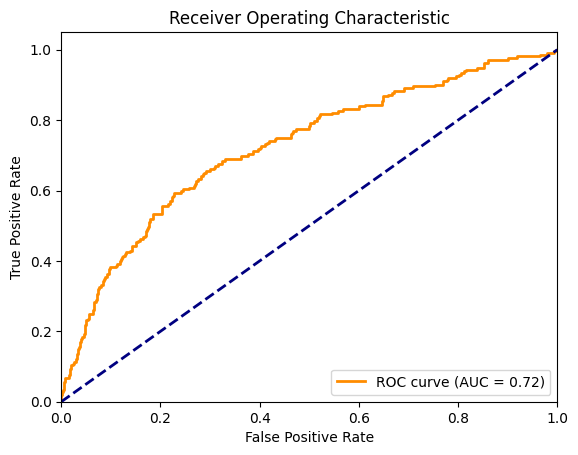

Accuracy: 0.68
Sensitivity: 0.68
Specificity: 0.68
F1 Score: 0.56
AUC-ROC: 0.72
Confusion Matrix:
True Negative  : 321  	False Positive : 154  	
False Negative : 68   	True Positive  : 144  	
              precision    recall  f1-score   support

           0       0.83      0.68      0.74       475
           1       0.48      0.68      0.56       212

    accuracy                           0.68       687
   macro avg       0.65      0.68      0.65       687
weighted avg       0.72      0.68      0.69       687



In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load your data into a DataFrame (your_dataframe)

# Define the response variable (dependent variable) and predictor variables (independent variables)
response_variable = 'death_flag'
predictor_variables = ['total_icu_stays', 'total_icu_duration', 'total_vent_stays',
                       'total_vent_duration', 'avg_WBC_count', 'avg_body_temp', 'avg_bmi',
                       'age', 'charlson_comorbidity_index', 'Heart Rate',
                       'Respiratory Rate (Total)', 'Temperature Celsius',
                       'Alanine Aminotransferase (ALT)', 'Alkaline Phosphatase', 'Anion Gap',
                       'Bicarbonate', 'Bilirubin, Total', 'Chloride', 'Creatinine',
                       'Free Calcium', 'Hematocrit', 'Hemoglobin', 'Lactate', 'MCH', 'MCHC',
                       'MCV', 'PT', 'PTT', 'Potassium', 'RDW', 'Red Blood Cells', 'Sodium',
                       'Urea Nitrogen', 'White Blood Cells', 'pCO2', 'pH', 'pO2', 'gender_F',
                       'gender_M', 'bronchoscopy_0', 'bronchoscopy_1']

# Remove specific variables from the predictor variables
variables_to_remove = ['total_icu_duration', 'Bicarbonate', 'Hematocrit', 'Hemoglobin', 'MCV', 'Sodium', 'pH']
predictor_variables = [var for var in predictor_variables if var not in variables_to_remove]

# Create the design matrix (X) and response variable (y)
X = machine_learning_data_cleaned[predictor_variables]
y = machine_learning_data_cleaned[response_variable]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class_counts = y_train.value_counts()
total_samples = len(y_train)

class_weights = {0: total_samples / (2 * class_counts[0]), 1: total_samples / (2 * class_counts[1])}


# Fit a logistic regression model
model = LogisticRegression(class_weight=class_weights, max_iter=1000)  # Increase max_iter if necessary
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract true negatives, false positives, false negatives, and true positives from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Calculate specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate ROC AUC
y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class
roc_auc = roc_auc_score(y_test, y_prob)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'F1 Score: {f1_score:.2f}')
print(f'AUC-ROC: {roc_auc:.2f}')

# Define confusion matrix labels
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]

print("Confusion Matrix:")
for i in range(2):
    for j in range(2):
        print(f"{labels[i * 2 + j]:<15}: {conf_matrix[i][j]:<5}", end="\t")
    print()  # Start a new line for the next row

# Generate the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

In [ ]:
distinct_count = y_test.value_counts()
print(distinct_count)

0    475
1    212
Name: death_flag, dtype: int64


### Random Forest

In [ ]:
machine_learning_data_cleaned['death_flag'].value_counts()

0    1510
1     780
Name: death_flag, dtype: int64

Best n_estimators: 110


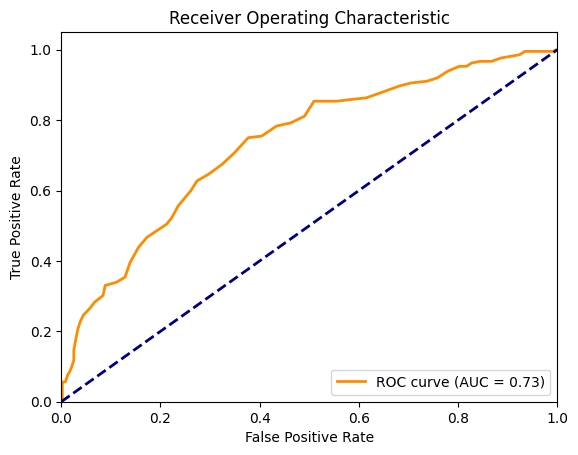

Accuracy: 0.68
Sensitivity: 0.26
Specificity: 0.94
Precision: 0.67
Recall: 0.26
F1 Score: 0.38
AUC-ROC: 0.73
Confusion Matrix:
[[448  27]
 [156  56]]
True Negative  : 448  	False Positive : 27   	
False Negative : 156  	True Positive  : 56   	
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       475
           1       0.67      0.26      0.38       212

    accuracy                           0.73       687
   macro avg       0.71      0.60      0.61       687
weighted avg       0.72      0.73      0.69       687



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Define the response variable (dependent variable) and predictor variables (independent variables)
response_variable = 'death_flag'
predictor_variables = ['total_icu_stays', 'total_icu_duration', 'total_vent_stays',
                       'total_vent_duration', 'avg_WBC_count', 'avg_body_temp', 'avg_bmi',
                       'age', 'charlson_comorbidity_index', 'Heart Rate',
                       'Respiratory Rate (Total)', 'Temperature Celsius',
                       'Alanine Aminotransferase (ALT)', 'Alkaline Phosphatase', 'Anion Gap',
                       'Bicarbonate', 'Bilirubin, Total', 'Chloride', 'Creatinine',
                       'Free Calcium', 'Hematocrit', 'Hemoglobin', 'Lactate', 'MCH', 'MCHC',
                       'MCV', 'PT', 'PTT', 'Potassium', 'RDW', 'Red Blood Cells', 'Sodium',
                       'Urea Nitrogen', 'White Blood Cells', 'pCO2', 'pH', 'pO2', 'gender_F',
                       'gender_M', 'bronchoscopy_0', 'bronchoscopy_1']

# Remove specific variables from the predictor variables
variables_to_remove = ['total_icu_duration', 'Bicarbonate', 'Hematocrit', 'Hemoglobin', 'MCV', 'Sodium', 'pH']
predictor_variables = [var for var in predictor_variables if var not in variables_to_remove]

X = machine_learning_data_cleaned[predictor_variables]
y = machine_learning_data_cleaned[response_variable]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

best_n_estimators = None
best_accuracy = 0
class_counts = y_train.value_counts()
total_samples = len(y_train)

class_weights = {0: total_samples / (2 * class_counts[0]), 1: total_samples / (2 * class_counts[1])}


for n_estimators in range(10, 201, 50):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, class_weight=class_weights)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()

    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_n_estimators = n_estimators

print(f"Best n_estimators: {best_n_estimators}")

best_clf = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42,class_weight=class_weights)
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract true negatives, false positives, false negatives, and true positives from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Calculate specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate ROC AUC
y_prob = best_clf.predict_proba(X_test)[:, 1]  # Probability of the positive class
roc_auc = roc_auc_score(y_test, y_prob)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')  # Changed from "F1 Score" to "Precision"
print(f'Recall: {recall:.2f}')  # Changed from "Precision" to "Recall"
print(f'F1 Score: {f1_score:.2f}')
print(f'AUC-ROC: {roc_auc:.2f}')

# Define confusion matrix labels
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]

print("Confusion Matrix:")
print(conf_matrix)
for i in range(2):
    for j in range(2):
        print(f"{labels[i * 2 + j]:<15}: {conf_matrix[i][j]:<5}", end="\t")
    print()  # Start a new line for the next row

# Generate the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

In [ ]:
distinct_count = y_test.value_counts()
print(distinct_count)

0    475
1    212
Name: death_flag, dtype: int64


### XG BOost

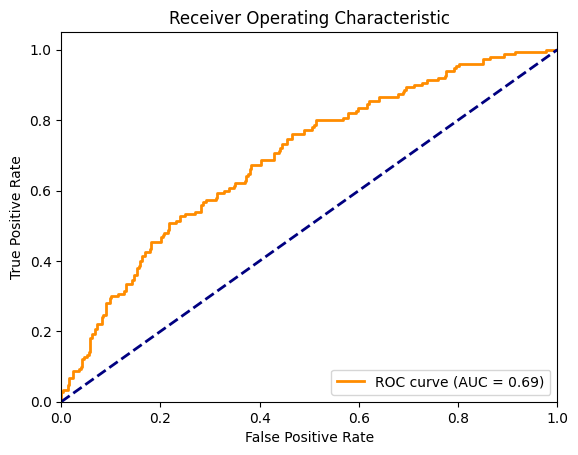

Accuracy: 0.69
Sensitivity: 0.47
Specificity: 0.80
Precision: 0.53
Recall: 0.47
F1 Score: 0.50
AUC-ROC: 0.69
Confusion Matrix:
[[246  62]
 [ 80  70]]
True Negative  : 246  	False Positive : 62   	
False Negative : 80   	True Positive  : 70   	
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       308
           1       0.53      0.47      0.50       150

    accuracy                           0.69       458
   macro avg       0.64      0.63      0.64       458
weighted avg       0.68      0.69      0.68       458



In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load your data into a DataFrame (your_dataframe)

# Define the response variable (dependent variable) and predictor variables (independent variables)
response_variable = 'death_flag'
predictor_variables = ['total_icu_stays', 'total_icu_duration', 'total_vent_stays',
                       'total_vent_duration', 'avg_WBC_count', 'avg_body_temp', 'avg_bmi',
                       'age', 'charlson_comorbidity_index', 'Heart Rate',
                       'Respiratory Rate (Total)', 'Temperature Celsius',
                       'Alanine Aminotransferase (ALT)', 'Alkaline Phosphatase', 'Anion Gap',
                       'Bicarbonate', 'Bilirubin, Total', 'Chloride', 'Creatinine',
                       'Free Calcium', 'Hematocrit', 'Hemoglobin', 'Lactate', 'MCH', 'MCHC',
                       'MCV', 'PT', 'PTT', 'Potassium', 'RDW', 'Red Blood Cells', 'Sodium',
                       'Urea Nitrogen', 'White Blood Cells', 'pCO2', 'pH', 'pO2', 'gender_F',
                       'gender_M', 'bronchoscopy_0', 'bronchoscopy_1']

# Remove specific variables from the predictor variables
variables_to_remove = ['total_icu_duration', 'Bicarbonate', 'Hematocrit', 'Hemoglobin', 'MCV', 'Sodium', 'pH']
predictor_variables = [var for var in predictor_variables if var not in variables_to_remove]

# Create the design matrix (X) and response variable (y)
X = machine_learning_data_cleaned[predictor_variables]
y = machine_learning_data_cleaned[response_variable]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tackle the class imbalance problem by calculating the scale_pos_weight
positive_samples = sum(y_train == 1)
negative_samples = sum(y_train == 0)
scale_pos_weight = negative_samples / positive_samples

# Create and train the XGBoost model with class imbalance handling
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract true negatives, false positives, false negatives, and true positives from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Calculate specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1_score = f1_score(y_test, y_pred)

# Calculate ROC AUC
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')
print(f'AUC-ROC: {roc_auc:.2f}')

# Define confusion matrix labels
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]

print("Confusion Matrix:")
print(conf_matrix)
for i in range(2):
    for j in range(2):
        print(f"{labels[i * 2 + j]:<15}: {conf_matrix[i][j]:<5}", end="\t")
    print()  # Start a new line for the next row

# Generate the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

In [ ]:
distinct_count = y_test.value_counts()
print(distinct_count)

0    308
1    150
Name: death_flag, dtype: int64


###Support Vector Machine (SVM)

{0: 0.7743961352657005, 1: 1.4110915492957747}


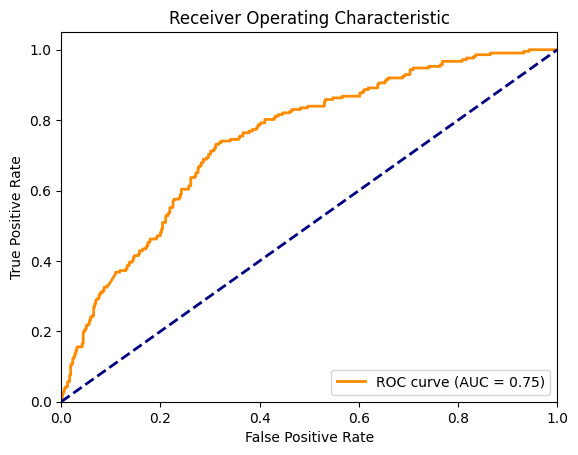

Accuracy: 0.70
Sensitivity: 0.70
Specificity: 0.70
Precision: 0.51
Recall: 0.70
F1 Score: 0.59
AUC-ROC: 0.75
Confusion Matrix:
[[332 143]
 [ 63 149]]
True Negative  : 332  	False Positive : 143  	
False Negative : 63   	True Positive  : 149  	
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       475
           1       0.51      0.70      0.59       212

    accuracy                           0.70       687
   macro avg       0.68      0.70      0.68       687
weighted avg       0.74      0.70      0.71       687



In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load your data into a DataFrame (your_dataframe)

# Define the response variable (dependent variable) and predictor variables (independent variables)
response_variable = 'death_flag'
predictor_variables = ['total_icu_stays', 'total_icu_duration', 'total_vent_stays',
                       'total_vent_duration', 'avg_WBC_count', 'avg_body_temp', 'avg_bmi',
                       'age', 'charlson_comorbidity_index', 'Heart Rate',
                       'Respiratory Rate (Total)', 'Temperature Celsius',
                       'Alanine Aminotransferase (ALT)', 'Alkaline Phosphatase', 'Anion Gap',
                       'Bicarbonate', 'Bilirubin, Total', 'Chloride', 'Creatinine',
                       'Free Calcium', 'Hematocrit', 'Hemoglobin', 'Lactate', 'MCH', 'MCHC',
                       'MCV', 'PT', 'PTT', 'Potassium', 'RDW', 'Red Blood Cells', 'Sodium',
                       'Urea Nitrogen', 'White Blood Cells', 'pCO2', 'pH', 'pO2', 'gender_F',
                       'gender_M', 'bronchoscopy_0', 'bronchoscopy_1']

# Remove specific variables from the predictor variables
variables_to_remove = ['total_icu_duration', 'Bicarbonate', 'Hematocrit', 'Hemoglobin', 'MCV', 'Sodium', 'pH']
predictor_variables = [var for var in predictor_variables if var not in variables_to_remove]

# Create the design matrix (X) and response variable (y)
X = machine_learning_data_cleaned[predictor_variables]
y = machine_learning_data_cleaned[response_variable]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class_counts = y_train.value_counts()
total_samples = len(y_train)

class_weights = {0: total_samples / (2 * class_counts[0]), 1: total_samples / (2 * class_counts[1])}
print(class_weights)

# Tackle the class imbalance problem by using class_weight="balanced"
svm_model = SVC(class_weight=class_weights, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract true negatives, false positives, false negatives, and true positives from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Calculate specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1_score = f1_score(y_test, y_pred)

# Calculate ROC AUC
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')
print(f'AUC-ROC: {roc_auc:.2f}')

# Define confusion matrix labels
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]

print("Confusion Matrix:")
print(conf_matrix)
for i in range(2):
    for j in range(2):
        print(f"{labels[i * 2 + j]:<15}: {conf_matrix[i][j]:<5}", end="\t")
    print()  # Start a new line for the next row

# Generate the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

In [ ]:
distinct_count = y_test.value_counts()
print(distinct_count)

0    475
1    212
Name: death_flag, dtype: int64


## Machine Learning Model (NULL VALUES HANDLED) _ INCLUDES THE SUBSET OF FEATURES

1. We have removed the columns which has more than 40% Null Values.

2. For the remaining columns, we substitute the null values by the average means of the column.

Run the above part first

### Selecting the features

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

target_variable = machine_learning_data_cleaned['death_flag']
columns_to_exclude = ['death_flag', 'gender_F', 'gender_M', 'bronchoscopy_0', 'bronchoscopy_1']
features = machine_learning_data_cleaned.drop(columns=columns_to_exclude)
standardized_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Combine the standardized features and the columns you want to keep without scaling
standardized_data = pd.concat([standardized_features, machine_learning_data_cleaned[columns_to_exclude]], axis=1)
standardized_data['death_flag'] = target_variable

In [ ]:
#run the above part
standardized_data.columns

Index(['total_icu_stays', 'total_vent_stays', 'total_vent_duration',
       'avg_WBC_count', 'avg_body_temp', 'avg_bmi', 'age',
       'charlson_comorbidity_index', 'Heart Rate', 'Respiratory Rate (Total)',
       'Temperature Celsius', 'Alanine Aminotransferase (ALT)',
       'Alkaline Phosphatase', 'Anion Gap', 'Bilirubin, Total', 'Chloride',
       'Creatinine', 'Free Calcium', 'Lactate', 'MCH', 'MCHC', 'PT', 'PTT',
       'Potassium', 'RDW', 'Red Blood Cells', 'Urea Nitrogen',
       'White Blood Cells', 'pCO2', 'pO2', 'death_flag', 'gender_F',
       'gender_M', 'bronchoscopy_0', 'bronchoscopy_1'],
      dtype='object')

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Assuming X is your feature matrix and y is the target variable
X = standardized_data[['total_icu_stays', 'total_vent_stays', 'total_vent_duration',
       'avg_WBC_count', 'avg_body_temp', 'avg_bmi', 'age',
       'charlson_comorbidity_index', 'Heart Rate', 'Respiratory Rate (Total)',
       'Temperature Celsius', 'Alanine Aminotransferase (ALT)',
       'Alkaline Phosphatase', 'Anion Gap', 'Bilirubin, Total', 'Chloride',
       'Creatinine', 'Free Calcium', 'Lactate', 'MCH', 'MCHC', 'PT', 'PTT',
       'Potassium', 'RDW', 'Red Blood Cells', 'Urea Nitrogen',
       'White Blood Cells', 'pCO2', 'pO2', 'gender_F', 'gender_M', 'bronchoscopy_0', 'bronchoscopy_1']]
y = standardized_data['death_flag']

# Create an estimator (e.g., Random Forest)
estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a cross-validation generator
cv = StratifiedKFold(n_splits=5)  # You can change the number of folds

# Create an RFECV selector
rfecv = RFECV(estimator, step=1, cv=cv, scoring='roc_auc')  # You can change the scoring metric

# Fit the RFECV selector to your data
rfecv.fit(X, y)

# Get the selected features
selected_features = X.columns[rfecv.support_]

# Print the selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)

# Print the optimal number of features
print("Optimal Number of Features:", rfecv.n_features_)

Selected Features:
total_vent_duration
avg_WBC_count
avg_body_temp
avg_bmi
age
Heart Rate
Respiratory Rate (Total)
Temperature Celsius
Chloride
Creatinine
Lactate
MCH
MCHC
PT
PTT
RDW
Red Blood Cells
Urea Nitrogen
White Blood Cells
pCO2
pO2
Optimal Number of Features: 21


In [ ]:
selected_features_list = selected_features.tolist()

In [ ]:
selected_features_list = selected_features_list + ['bronchoscopy_0', 'bronchoscopy_1']

In [ ]:
standardized_data_red = standardized_data.copy()

In [ ]:
standardized_data_red = standardized_data_red[selected_features_list + ['death_flag']]

###Support Vector Machine (SVM)

{0: 0.7743961352657005, 1: 1.4110915492957747}


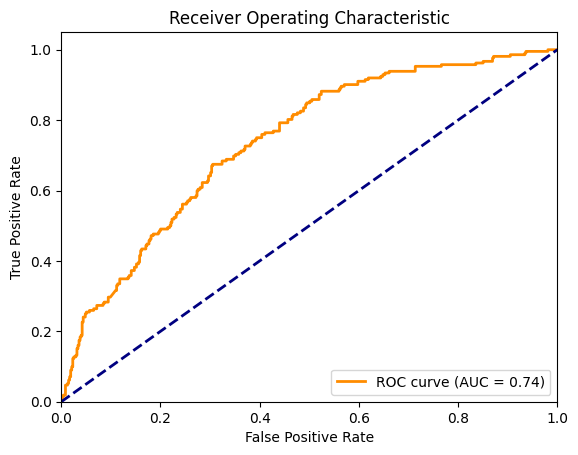

Accuracy: 0.67
Sensitivity: 0.69
Specificity: 0.65
Precision: 0.47
Recall: 0.69
F1 Score: 0.56
AUC-ROC: 0.74
Confusion Matrix:
[[310 165]
 [ 65 147]]
True Negative  : 310  	False Positive : 165  	
False Negative : 65   	True Positive  : 147  	
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       475
           1       0.47      0.69      0.56       212

    accuracy                           0.67       687
   macro avg       0.65      0.67      0.65       687
weighted avg       0.72      0.67      0.68       687



In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load your data into a DataFrame (your_dataframe)

# Define the response variable (dependent variable) and predictor variables (independent variables)
response_variable = 'death_flag'
predictor_variables = selected_features_list

# Create the design matrix (X) and response variable (y)
X = standardized_data_red[predictor_variables]
y = standardized_data_red[response_variable]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_counts = y_train.value_counts()
total_samples = len(y_train)

class_weights = {0: total_samples / (2 * class_counts[0]), 1: total_samples / (2 * class_counts[1])}
print(class_weights)

# Tackle the class imbalance problem by using class_weight="balanced"
svm_model = SVC(class_weight=class_weights, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract true negatives, false positives, false negatives, and true positives from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Calculate specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1_score = f1_score(y_test, y_pred)

# Calculate ROC AUC
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')
print(f'AUC-ROC: {roc_auc:.2f}')

# Define confusion matrix labels
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]

print("Confusion Matrix:")
print(conf_matrix)
for i in range(2):
    for j in range(2):
        print(f"{labels[i * 2 + j]:<15}: {conf_matrix[i][j]:<5}", end="\t")
    print()  # Start a new line for the next row

# Generate the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

### Logistic Regression

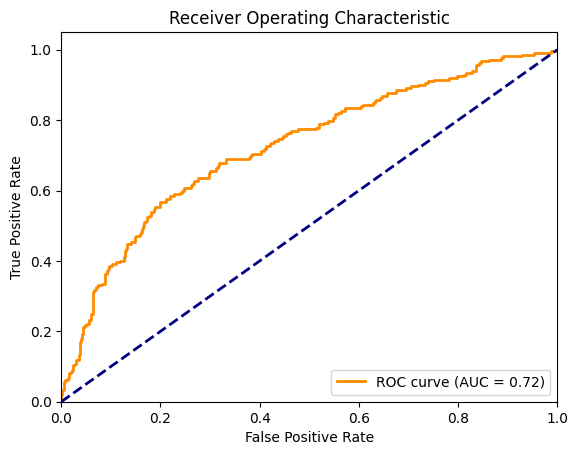

Accuracy: 0.67
Sensitivity: 0.68
Specificity: 0.67
F1 Score: 0.56
AUC-ROC: 0.72
Confusion Matrix:
True Negative  : 318  	False Positive : 157  	
False Negative : 68   	True Positive  : 144  	
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       475
           1       0.48      0.68      0.56       212

    accuracy                           0.67       687
   macro avg       0.65      0.67      0.65       687
weighted avg       0.72      0.67      0.68       687



In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load your data into a DataFrame (your_dataframe)

# Define the response variable (dependent variable) and predictor variables (independent variables)
# Define the response variable (dependent variable) and predictor variables (independent variables)
response_variable = 'death_flag'
predictor_variables = selected_features_list

# Create the design matrix (X) and response variable (y)
X = standardized_data_red[predictor_variables]
y = standardized_data_red[response_variable]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_counts = y_train.value_counts()
total_samples = len(y_train)

class_weights = {0: total_samples / (2 * class_counts[0]), 1: total_samples / (2 * class_counts[1])}


# Fit a logistic regression model
model = LogisticRegression(class_weight=class_weights, max_iter=1000)  # Increase max_iter if necessary
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract true negatives, false positives, false negatives, and true positives from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Calculate specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate ROC AUC
y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class
roc_auc = roc_auc_score(y_test, y_prob)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'F1 Score: {f1_score:.2f}')
print(f'AUC-ROC: {roc_auc:.2f}')

# Define confusion matrix labels
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]

print("Confusion Matrix:")
for i in range(2):
    for j in range(2):
        print(f"{labels[i * 2 + j]:<15}: {conf_matrix[i][j]:<5}", end="\t")
    print()  # Start a new line for the next row

# Generate the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

## **Clustering**

In [ ]:
standardized_data_red.columns

Index(['total_vent_duration', 'avg_WBC_count', 'avg_body_temp', 'avg_bmi',
       'age', 'Heart Rate', 'Respiratory Rate (Total)', 'Temperature Celsius',
       'Chloride', 'Creatinine', 'Lactate', 'MCH', 'MCHC', 'PT', 'PTT', 'RDW',
       'Red Blood Cells', 'Urea Nitrogen', 'White Blood Cells', 'pCO2', 'pO2',
       'bronchoscopy_0', 'bronchoscopy_1', 'death_flag'],
      dtype='object')

## Survival Count

In [ ]:
# Print the total number of patients in the dataset
print(f"Total patients in the cohort: {len(standardized_data_red)}")

# Count the number of non-deceased patients (where 'dod' is null)
count_non_deceased = standardized_data_red['death_flag'].value_counts()
print("dod column information")
# Print the count of non-deceased patients
print(f"Number of Non-Deceased Patients: {count_non_deceased}\n\n")


Total patients in the cohort: 2290
dod column information
Number of Non-Deceased Patients: 0    1510
1     780
Name: death_flag, dtype: int64




## Removing Outliers

- **get_whisker_range:** The get_whisker_range function calculates and prints the lower and upper whisker values. It is used to eliminate the outliers.

- **box_plot:**  This function creates a box plot for selected columns in a dataset. It also calculates the whisker range for the columns by calling the get_whisker_range function for the outlier removal process.

- **remove_outliers:** This function filters out outliers from the dataset based on the specified bounds
- **comparision_plot:** This function plots the comparison between different statistics for the original and outlier-removed dataset
- **feature_scaling:** This function standardizes the numeric columns of the dataset

In [ ]:
#Data Manipulation

import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

#Clustering

from sklearn.preprocessing import StandardScaler  # For data scaling
from sklearn.cluster import KMeans  # For K-means clustering
from sklearn.decomposition import PCA  # For Principal Component Analysis
from sklearn.metrics import silhouette_score # For Silhouette score

# Function to calculate and print the lower and upper whisker values for the columns
def get_whisker_range(dataset, columns_to_exclude):
    # Select columns to analyze, excluding those in 'columns_to_exclude'
    selected_columns = [col for col in dataset.columns if col not in columns_to_exclude]

    # Initialize a dictionary to store whisker values for each column
    whisker_dict = {}

    # Calculate whisker values for each selected column
    for column in selected_columns:
        Q1 = dataset[column].quantile(0.25)
        Q3 = dataset[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Store the whisker values in the dictionary
        whisker_dict[column] = {'Lower Whisker': lower_bound, 'Upper Whisker': upper_bound}

        # Filter the dataset to include only data within the whisker range
        dataset = dataset[(dataset[column] >= lower_bound) & (dataset[column] <= upper_bound)]

    # Print the whisker values for each column
    for col, values in whisker_dict.items():
        print(f"Column: {col}")
        print(f"Lower Whisker: {values['Lower Whisker']}")
        print(f"Upper Whisker: {values['Upper Whisker']}\n")

    return whisker_dict


# function to visualize the box plots and return the values of the IQR range of the box plot
def box_plot(dataset, columns_to_exclude, disp):

    # Drop specified columns from the dataset
    dataset = dataset.drop(columns=columns_to_exclude)

    #get whisker range
    whisker_dict = get_whisker_range(dataset, columns_to_exclude )

    if (disp == True):
        # Create a box plot for the remaining columns
        boxplot = dataset.boxplot(figsize=(10, 7))

        # Add a title to the box plot
        plt.title('Box Plot for Selected Columns')
        # Show the plot
        plt.show()

    return whisker_dict

# Function to remove outliers from a dataset based on lower and upper bounds for each column
def remove_outliers(bounds, dataset, columns_to_exclude):

    # Get the list of columns after excluding non-numeric columns
    selected_columns = [col for col in dataset.columns if col not in columns_to_exclude]

    # Iterate through selected columns and filter out outliers
    for col in selected_columns:
        lower_bound = bounds[col]['Lower Whisker']
        upper_bound = bounds[col]['Upper Whisker']
        dataset = dataset[(dataset[col] >= lower_bound) & (dataset[col] <= upper_bound)]

    #return clean dataset with removed outliers
    return dataset

# plot the comparison graph between the summary statistics of the original and outlier-removed dataset
def comparision_plot(statistics_to_compare, dataset,summary_stats,cleaned_data_summary_stats, columns_to_exclude ):


    # Select columns to analyze, excluding those in 'columns_to_exclude'
    selected_columns = [col for col in dataset.columns if col not in columns_to_exclude]

    # Create an empty DataFrame to store the statistics for comparison
    comparison_df = pd.DataFrame({'Column': selected_columns})

    # Creating a dataframe that contains the statistics value for both the dataset (with and without outliers)
    for stat in statistics_to_compare:
        mean_original = summary_stats.loc[stat, selected_columns].values
        mean_no_outliers = cleaned_data_summary_stats.loc[stat, selected_columns].values
        comparison_df[f'{stat}_Original'] = mean_original
        comparison_df[f'{stat}_No_Outliers'] = mean_no_outliers
        print (f"Difference in {stat} statistic between original and cleaned dataset is\n")
        diff = abs(cleaned_data_summary_stats.loc[stat] - summary_stats.loc[stat])
        print(diff)
        print("\n")
        print (f"Percentage change in {stat} statistic between original and cleaned dataset is\n")
        print((diff / summary_stats.loc[stat]) * 100)
        print("\n")

    # To better visualization, we set the index
    comparison_df.set_index('Column', inplace=True)

    # Create a bar chart to compare the statistics
    ax = comparison_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', width=0.7)
    ax.set_title('Comparison of Summary Statistics (Original vs. No Outliers)')
    ax.set_xlabel('Column')
    ax.set_ylabel('Value')
    ax.set_xticklabels(selected_columns, rotation=45, ha="right")
    ax.legend(title='Dataset', loc='upper right', bbox_to_anchor=(1.15, 1))

    # Annotate the bars with values
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

    # Show the plot
    plt.tight_layout()
    plt.show()

#Standardize selected numeric columns in the dataset to have mean=0 and standard deviation=1
def feature_scaling(dataset, columns_to_exclude):

    # initialize StandardScaler
    scaler = StandardScaler()

    selected_columns = [col for col in dataset.columns if col not in columns_to_exclude]

    # Apply the scaler to the selected columns
    dataset[selected_columns] = scaler.fit_transform(dataset[selected_columns])
    return dataset, scaler

In [ ]:
whisker_info = box_plot(standardized_data_red, ['death_flag'], disp = False)

Column: total_vent_duration
Lower Whisker: -1.865975038257674
Upper Whisker: 1.5054322971441945

Column: avg_WBC_count
Lower Whisker: -1.2788862354273614
Upper Whisker: 1.178522125632674

Column: avg_body_temp
Lower Whisker: -0.15062138934878772
Upper Whisker: -0.03644541413582418

Column: avg_bmi
Lower Whisker: -1.7469126253534049
Upper Whisker: 1.5532022803736187

Column: age
Lower Whisker: -2.5889997942437937
Upper Whisker: 2.814658301770706

Column: Heart Rate
Lower Whisker: -2.69072908498388
Upper Whisker: 2.475491480966074

Column: Respiratory Rate (Total)
Lower Whisker: -1.2294263605758675
Upper Whisker: 0.9644598612469957

Column: Temperature Celsius
Lower Whisker: -0.5699128832698868
Upper Whisker: 0.6567637020098112

Column: Chloride
Lower Whisker: -2.1171189114477995
Upper Whisker: 2.299849577077663

Column: Creatinine
Lower Whisker: -1.3634494783693172
Upper Whisker: 0.8180696870215902

Column: Lactate
Lower Whisker: -1.6564064440983226
Upper Whisker: 1.0646001179953015

Co

In [ ]:
standardized_data_red_cleaned = remove_outliers(whisker_info, standardized_data_red, ['death_flag'])

In [ ]:
standardized_data_red_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 2288
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   total_vent_duration       629 non-null    float64
 1   avg_WBC_count             629 non-null    float64
 2   avg_body_temp             629 non-null    float64
 3   avg_bmi                   629 non-null    float64
 4   age                       629 non-null    float64
 5   Heart Rate                629 non-null    float64
 6   Respiratory Rate (Total)  629 non-null    float64
 7   Temperature Celsius       629 non-null    float64
 8   Chloride                  629 non-null    float64
 9   Creatinine                629 non-null    float64
 10  Lactate                   629 non-null    float64
 11  MCH                       629 non-null    float64
 12  MCHC                      629 non-null    float64
 13  PT                        629 non-null    float64
 14  PTT      

#K-Means

In [ ]:
#Defining a function that will perform k_means clustering for different k values
def k_means_clustering(tot_clusters, data, clustering_columns ):

    data = data.copy()

    kmeans = KMeans(n_clusters= tot_clusters, random_state=0, n_init=10, init = "k-means++")
    kmeans.fit(data[clustering_columns])

    #Find which cluster each data-point belongs to
    clusters = kmeans.predict(data[clustering_columns])

    #Add the cluster information as a new column to our DataFrame
    data["cluster"] = clusters

    return data

#Display the cumulative variance plot that is used to decide the number of PCA components
def cummulative_variance_plot(dataset, columns, title):

    #First we determine the number of principal components
    pca = PCA()
    pca.fit(dataset[columns])

    # Get explained variance ratio for each PC
    explained_variance_ratio = pca.explained_variance_ratio_

    # Create a Scree plot
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(explained_variance_ratio))
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance")
    plt.title(f"cumulative variance plot for {title}")
    plt.grid(True)
    plt.show()


# Perform PCA analysis and visualizes first 2 Principal components (2-D visualization)
def plot_pc_analysis(data, num_clusters):

    # PCA with 2 principal components
    pca_2d = PCA(n_components=2)

    # Calculate the 2 principal components
    PCs_2d = pd.DataFrame(pca_2d.fit_transform(data.drop(["cluster"], axis=1)))
    PCs_2d.columns = ["PC1", "PC2"]

    # Combine original data with the 2 principal components
    pca_df = pd.concat([data, PCs_2d], axis=1, join='inner')

    # Colors for clusters (red, green, blue, yellow)
    cluster_colors = ['r', 'g', 'b', 'y']

    # Create a scatter plot for each cluster
    plt.figure(figsize=(8, 6))

    for cluster_id in range(num_clusters):
        # Filter data for the current cluster
        cluster_data = pca_df[pca_df['cluster'] == cluster_id]

        # Plot cluster data points
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster_id}', c=cluster_colors[cluster_id])

        # Calculate and plot the cluster centroid
        centroid = cluster_data[['PC1', 'PC2']].mean()
        plt.scatter(centroid[0], centroid[1], marker='o', s=50, c='black', label=f'Centroid {cluster_id}')

        # Add cluster number label near the centroid
        plt.text(centroid[0] + 0.1, centroid[1] + 0.1, f'Cluster {cluster_id}', fontsize=12)


    # Set the plot components
    plt.title(f'PCA Components for Clusters K = {num_clusters}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=cluster_colors[cluster_id], label=f'Cluster {cluster_id}')
                       for cluster_id in range(num_clusters)]
    plt.legend(handles=legend_elements, loc='upper right')


    plt.grid(True)
    # Display the scatter plot with centroids
    plt.show()

In [ ]:
#From the previous section we have defined a list columns_to_exclude which include categorical and index parameters
columns_to_exclude = ['death_flag']

#As the first step of the k-means clustering, we will define the list of the columns that we will use for clustering
numeric_columns = [col for col in standardized_data_red_cleaned.columns if col not in columns_to_exclude]
clustering_columns = numeric_columns

print (clustering_columns)

['total_vent_duration', 'avg_WBC_count', 'avg_body_temp', 'avg_bmi', 'age', 'Heart Rate', 'Respiratory Rate (Total)', 'Temperature Celsius', 'Chloride', 'Creatinine', 'Lactate', 'MCH', 'MCHC', 'PT', 'PTT', 'RDW', 'Red Blood Cells', 'Urea Nitrogen', 'White Blood Cells', 'pCO2', 'pO2', 'bronchoscopy_0', 'bronchoscopy_1']


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto', init="k-means++")

# Fit the KMeans model to the scaled dataset using selected clustering columns
kmeans.fit(standardized_data_red_cleaned[clustering_columns])

KMeans(n_clusters=2, n_init='auto', random_state=0)

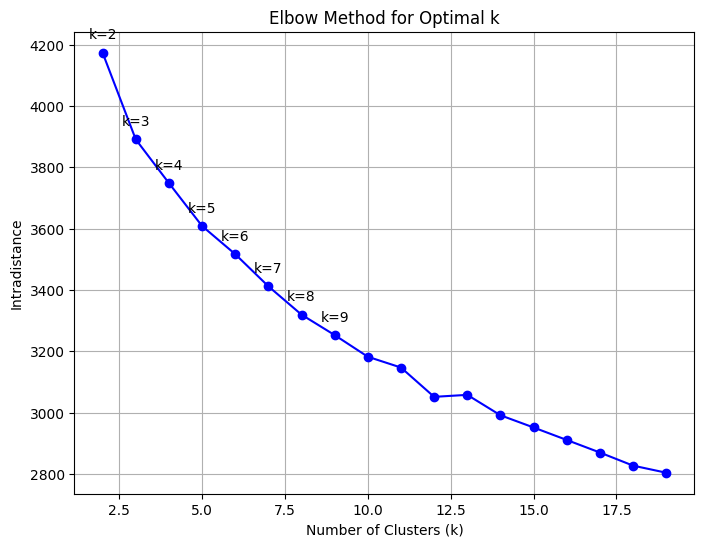

In [ ]:
# Calculate the intradistance for different values of k
intradistance = []

# List to store silhouette scores for different k values
silhouette_scores = []

# Loop through a range of k values from 2 to 19
for k in range(2, 20):
    # Initialize KMeans with the current k value
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto', init="k-means++")

    # Fit the KMeans model to the scaled dataset using selected clustering columns
    kmeans.fit(standardized_data_red_cleaned[clustering_columns])

    # Calculate and store the inertia (intradistance) for this k value
    intradistance.append(kmeans.inertia_)

    # Get cluster labels for data points
    cluster_labels = kmeans.fit_predict(standardized_data_red_cleaned[clustering_columns])

    # Calculate the silhouette score and store it
    silhouette_avg = silhouette_score(standardized_data_red_cleaned[clustering_columns], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 20), intradistance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Intradistance')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Annotate the points on the graph with k values
for i, k in enumerate(range(2, 10)):
    plt.annotate(f'k={k}', (k, intradistance[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Display the plot
plt.show()

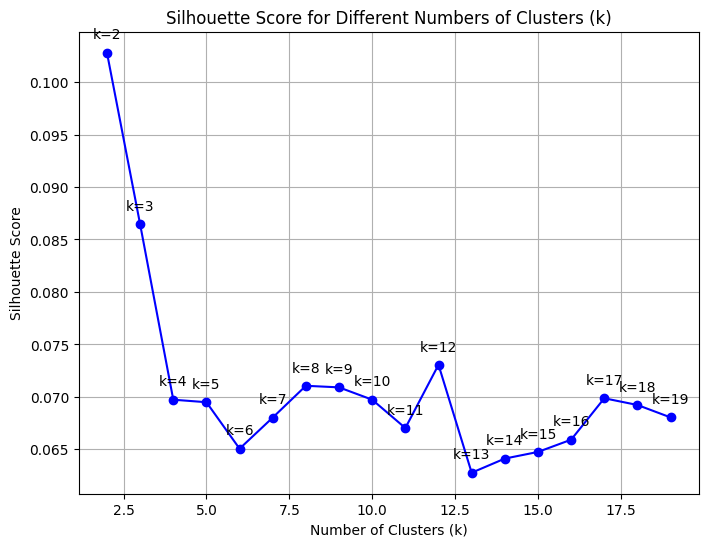

In [ ]:
# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Different Numbers of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Annotate the points with k values
for i, k in enumerate(range(2, 20)):
    plt.annotate(f'k={k}', (range(2, 20)[i], silhouette_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [ ]:
dataset_km_2 = k_means_clustering(2, standardized_data_red_cleaned, clustering_columns)
#dataset_km_4 = k_means_clustering(4, scaled_dataset, clustering_columns)

In [ ]:
# Print the count of data points in each cluster for k=3
cluster_3_info = dataset_km_2['cluster'].value_counts()
print("Dataset obtained after k-means clustering with k=3 contains the following cluster labels:")
for cluster, count in cluster_3_info.iteritems():
    print(f"- Cluster {cluster}: {count} data points")

print("\n")

Dataset obtained after k-means clustering with k=3 contains the following cluster labels:
- Cluster 0: 354 data points
- Cluster 1: 275 data points




<ipython-input-130-603bedef8d20>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cluster, count in cluster_3_info.iteritems():


## PCA

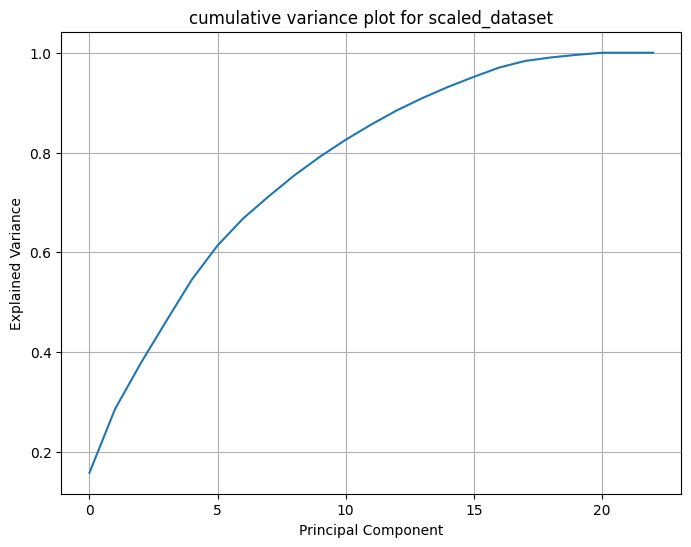

In [ ]:
cummulative_variance_plot(standardized_data_red_cleaned, clustering_columns, "scaled_dataset")

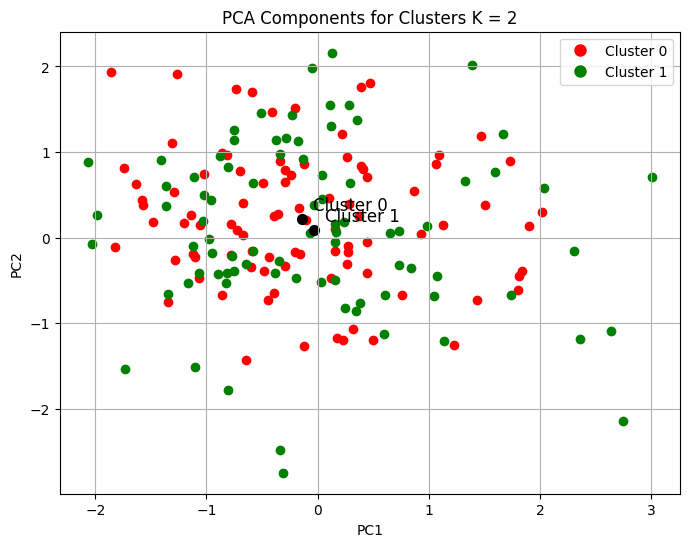

In [ ]:
#PCA analysis of dataset with 3 clusters
plot_pc_analysis(dataset_km_2,2)

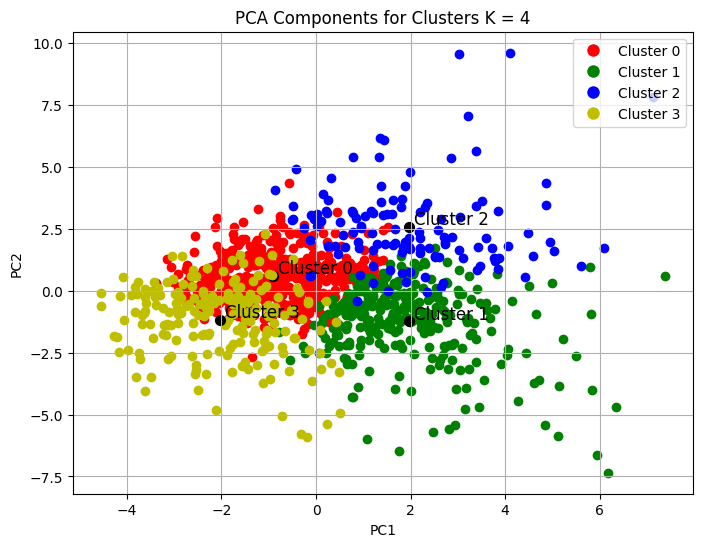

In [ ]:
# PCA analysis of dataset with K = 4 clusters
plot_pc_analysis(dataset_km_4,4)

## Selecting Cluster = 3

In [ ]:
# WILL DESCALE LATER
# create 3 different datasets (one for each cluster)
cluster_0 = dataset_km_3[dataset_km_3["cluster"] == 0]
cluster_1 = dataset_km_3[dataset_km_3["cluster"] == 1]
cluster_2 = dataset_km_3[dataset_km_3["cluster"] == 2]

In [ ]:
cluster_1.columns

Index(['total_icu_stays', 'total_icu_duration', 'total_vent_stays',
       'total_vent_duration', 'avg_wbc_count', 'avg_body_temp', 'avg_bmi',
       'age', 'death_flag', 'bronchoscopy', 'charlson_comorbidity_index',
       'heart_rate', 'respiratory_rate_(total)', 'temperature_celsius',
       'anion_gap', 'bicarbonate', 'chloride', 'creatinine', 'free_calcium',
       'hematocrit', 'hemoglobin', 'lactate', 'mch', 'mchc', 'mcv', 'pt',
       'ptt', 'potassium', 'rdw', 'red_blood_cells', 'sodium', 'urea_nitrogen',
       'white_blood_cells', 'pco2', 'ph', 'po2', 'gender_F', 'gender_M',
       'cluster'],
      dtype='object')

In [ ]:
cluster_0.head()

,total_icu_stays,total_icu_duration,total_vent_stays,total_vent_duration,avg_wbc_count,avg_body_temp,avg_bmi,age,death_flag,bronchoscopy,...,red_blood_cells,sodium,urea_nitrogen,white_blood_cells,pco2,ph,po2,gender_F,gender_M,cluster
1,-0.610334,-1.066115,-0.982942,-0.912399,0.045788,-0.113554,-0.233033,-1.509027,0.0,0,...,0.449643,0.537241,-1.278605,1.145688,-0.113416,0.828549,1.373607,0,1,0
2,-0.610334,-0.966230,-0.530254,-0.701539,-0.460757,-0.074840,-1.007752,0.738013,1.0,1,...,0.261460,0.174087,-0.644339,-0.112673,-0.697015,-0.282029,-0.510734,1,0,0
4,-0.610334,0.642307,-0.077567,1.162991,-0.111217,-0.106670,0.358298,0.160202,0.0,1,...,-1.128366,0.103474,-0.463120,0.489215,0.215857,0.830934,-0.158672,1,0,0
5,-0.610334,-0.881366,-0.982942,-0.602705,-2.290570,-0.091738,-0.059723,0.096001,1.0,1,...,-0.813092,-2.085532,-0.689643,1.834044,0.120024,0.601900,-1.331409,0,1,0
7,-0.224175,0.551093,0.827807,1.028314,-0.093969,-0.114001,-0.296087,0.930616,0.0,0,...,0.122220,1.307045,1.054926,-0.286354,-0.316901,0.601900,-0.045668,1,0,0


In [ ]:
# Assuming you have three DataFrames: cluster_0, cluster_1, and cluster_2
# Each DataFrame contains data for a different cluster

# Calculate the mortality rate for each cluster
mortality_rate_cluster_0 = cluster_0['death_flag'].mean()
mortality_rate_cluster_1 = cluster_1['death_flag'].mean()
mortality_rate_cluster_2 = cluster_2['death_flag'].mean()

# Create a summary DataFrame
mortality_summary = pd.DataFrame({
    'Cluster 0': mortality_rate_cluster_0,
    'Cluster 1': mortality_rate_cluster_1,
    'Cluster 2': mortality_rate_cluster_2
}, index=['Mortality Rate'])

# Beautify the output
mortality_summary.index.name = 'Cluster'

# Print the comparison results
print("Comparison of Mortality Rate per Cluster:")
print(mortality_summary)

Comparison of Mortality Rate per Cluster:
                Cluster 0  Cluster 1  Cluster 2
Cluster                                        
Mortality Rate   0.260504   0.403101   0.424419


In [ ]:
# Assuming you have three DataFrames: cluster_0, cluster_1, and cluster_2
# Each DataFrame contains data for a different cluster

# Calculate the mortality rate for each cluster
bronchoscopy_cluster_0 = cluster_0['bronchoscopy'].mean()
bronchoscopy_cluster_1 = cluster_1['bronchoscopy'].mean()
bronchoscopy_cluster_2 = cluster_2['bronchoscopy'].mean()

# Create a summary DataFrame
bronchoscopy_summary = pd.DataFrame({
    'Cluster 0': bronchoscopy_cluster_0,
    'Cluster 1': bronchoscopy_cluster_1,
    'Cluster 2': bronchoscopy_cluster_2
}, index=['Bronchoscopy info'])

# Beautify the output
bronchoscopy_summary.index.name = 'Cluster'

# Print the comparison results
print("Comparison of Bronchoscopy info per Cluster:")
print(bronchoscopy_summary)

Comparison of Bronchoscopy info per Cluster:
                   Cluster 0  Cluster 1  Cluster 2
Cluster                                           
Bronchoscopy info   0.515966   0.736434   0.468023


In [ ]:
# Assuming you have three DataFrames: cluster_0, cluster_1, and cluster_2
# Each DataFrame contains data for a different cluster

# Calculate the mortality rate for each cluster
bronchoscopy_cluster_0 = cluster_0['bronchoscopy'].mean()
bronchoscopy_cluster_1 = cluster_1['bronchoscopy'].mean()
bronchoscopy_cluster_2 = cluster_2['bronchoscopy'].mean()

# Create a summary DataFrame
bronchoscopy_summary = pd.DataFrame({
    'Cluster 0': bronchoscopy_cluster_0,
    'Cluster 1': bronchoscopy_cluster_1,
    'Cluster 2': bronchoscopy_cluster_2
}, index=['Bronchoscopy info'])

# Beautify the output
bronchoscopy_summary.index.name = 'Cluster'

# Print the comparison results
print("Comparison of Bronchoscopy info per Cluster:")
print(bronchoscopy_summary)

Comparison of Bronchoscopy info per Cluster:
                   Cluster 0  Cluster 1  Cluster 2
Cluster                                           
Bronchoscopy info   0.515966   0.736434   0.468023


In [ ]:
scaled_dataset.columns

Index(['subject_id', 'total_icu_stays', 'total_icu_duration',
       'total_vent_stays', 'total_vent_duration', 'avg_wbc_count',
       'avg_body_temp', 'avg_bmi', 'age', 'death_flag', 'bronchoscopy',
       'charlson_comorbidity_index', 'heart_rate', 'respiratory_rate_(total)',
       'temperature_celsius', 'anion_gap', 'bicarbonate', 'chloride',
       'creatinine', 'free_calcium', 'hematocrit', 'hemoglobin', 'lactate',
       'mch', 'mchc', 'mcv', 'pt', 'ptt', 'potassium', 'rdw',
       'red_blood_cells', 'sodium', 'urea_nitrogen', 'white_blood_cells',
       'pco2', 'ph', 'po2', 'gender_F', 'gender_M'],
      dtype='object')